In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import re
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pycaret.classification import *

In [3]:
path = "C:/Users/totoy/Documents/UNIVERSIDAD/PYTHON/PARCIAL 1/"

In [35]:
%%time
df = pd.read_csv(path  + 'train.csv')
prueba = pd.read_csv(path + "test.csv")

CPU times: total: 93.8 ms
Wall time: 1.16 s


### verificacion de datos faltantes

In [36]:
df = df.rename(columns={"Mother's occupation": "Mothers occupation", "Father's occupation": "Fathers occupation"})

In [37]:
prueba = prueba.rename(columns={"Mother's occupation": "Mothers occupation", "Father's occupation": "Fathers occupation"})

In [38]:
ft = pd.DataFrame(df.isnull().sum()).reset_index()
ft.columns = ["Variable","Faltantes"]
ft["% Faltantes"] = ft["Faltantes"] * 100 / df.shape[0]
ft.loc[ft["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [39]:
formato = pd.DataFrame({'Variable': list(df.columns), 'Formato': df.dtypes })
ft = pd.merge(ft,formato,on=["Variable"],how="left")
ft.head()

,Variable,Faltantes,% Faltantes,Formato
0,id,0,0.0,int64
1,Marital status,0,0.0,int64
2,Application mode,0,0.0,int64
3,Application order,0,0.0,int64
4,Course,0,0.0,int64


In [40]:
ft2 = pd.DataFrame(prueba.isnull().sum()).reset_index()
ft2.columns = ["Variable","Faltantes"]
ft2["% Faltantes"] = ft2["Faltantes"] * 100 / prueba.shape[0]
ft2.loc[ft2["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [41]:
df["Target"] = df["Target"].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})

In [42]:
df["Target"].unique()

array([2, 0, 1], dtype=int64)

In [43]:
ct = ['Gender', 'Displaced', 'Educational special needs', 'Debtor', 'Scholarship holder', 
      'International']

for k in ct:
    df[k] = df[k].astype("object")
    prueba[k] = prueba[k].astype("object")

In [44]:
numericas = list(formato.loc[formato["Formato"]!= "object",] ["Variable"])
numericas = [x for x in numericas if x not in ["Target", "id"]]

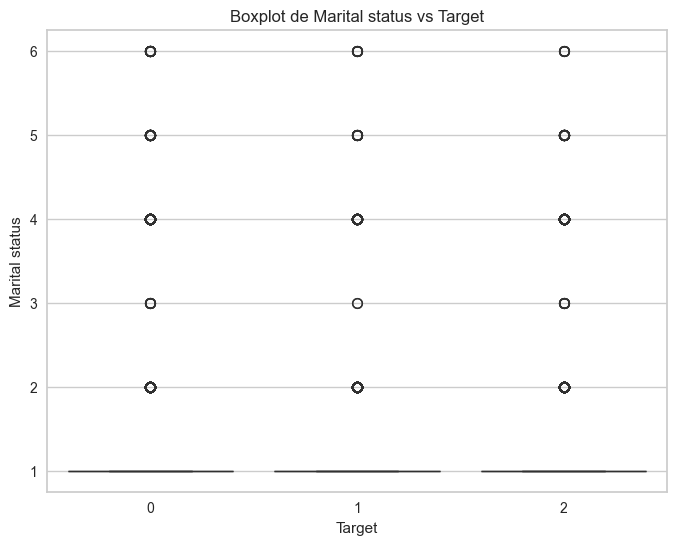

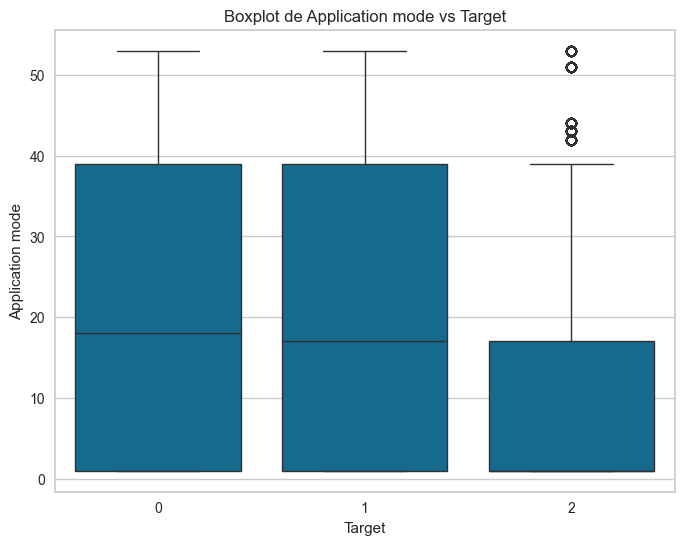

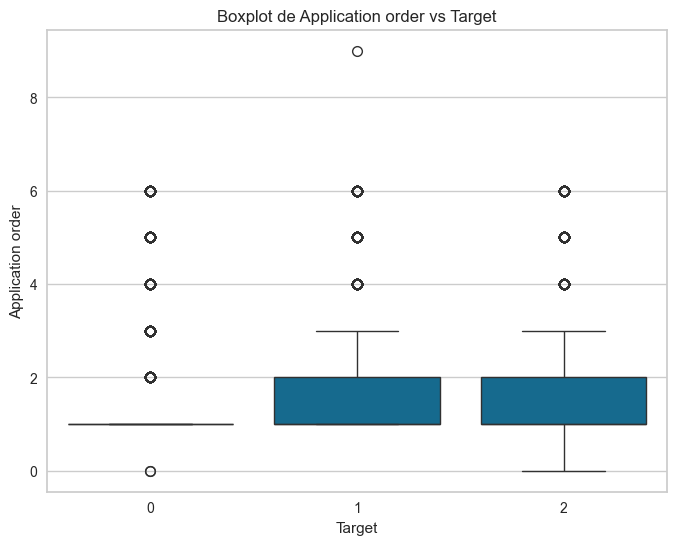

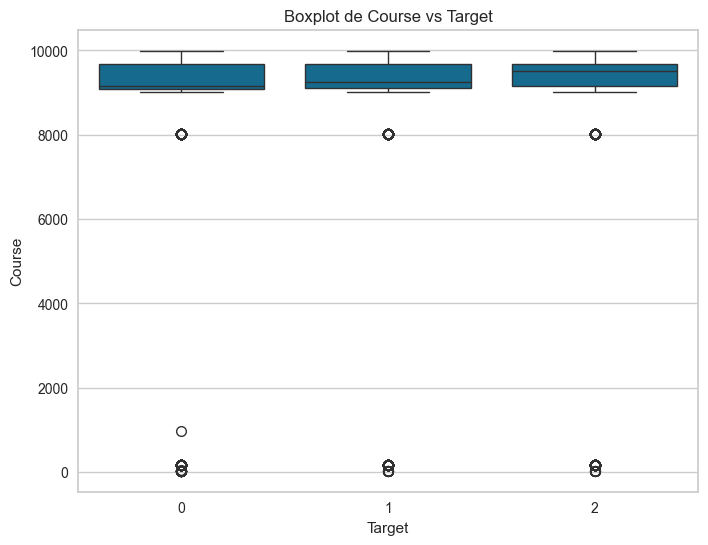

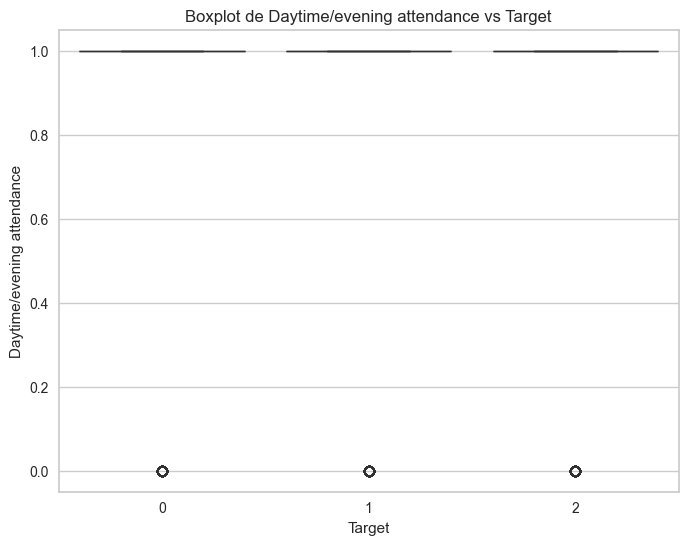

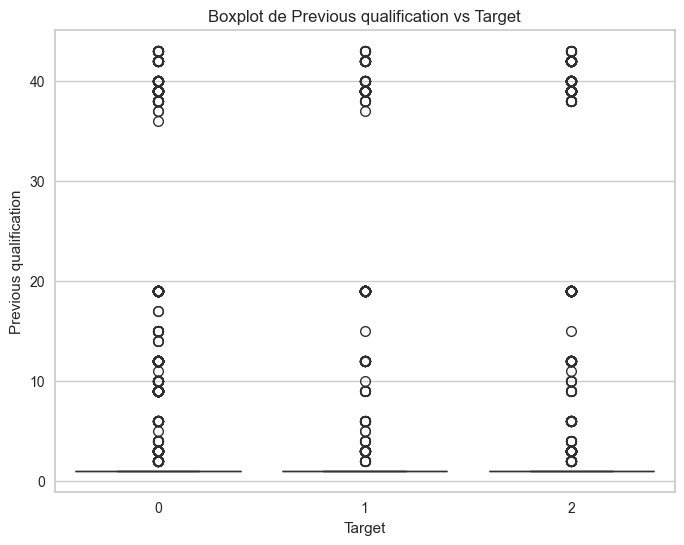

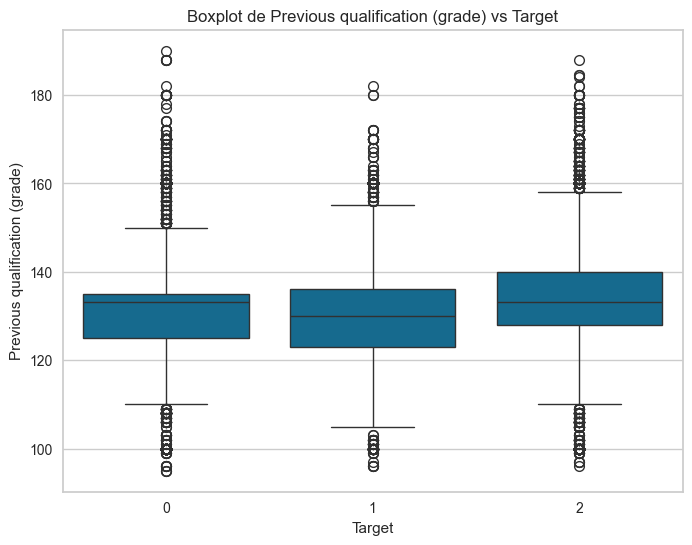

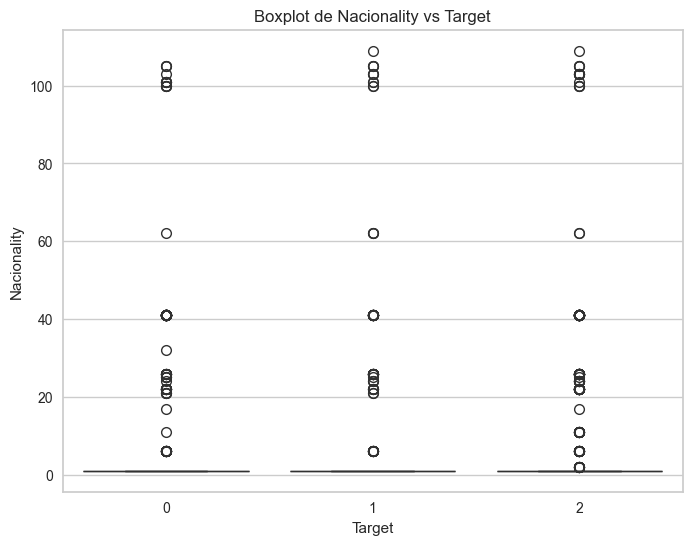

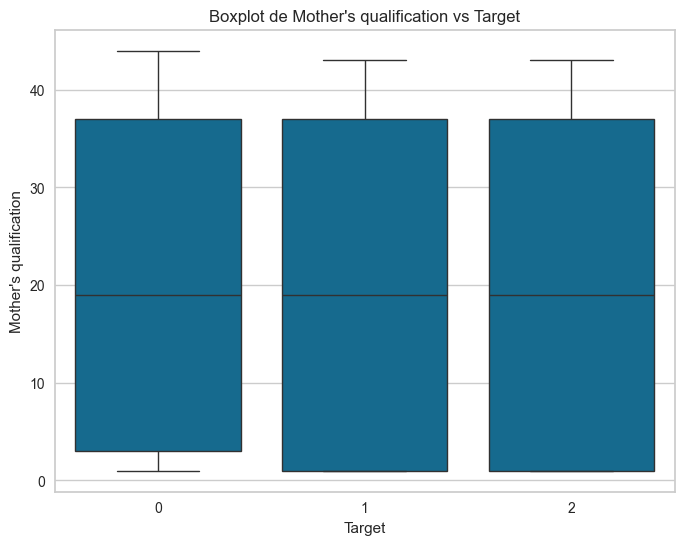

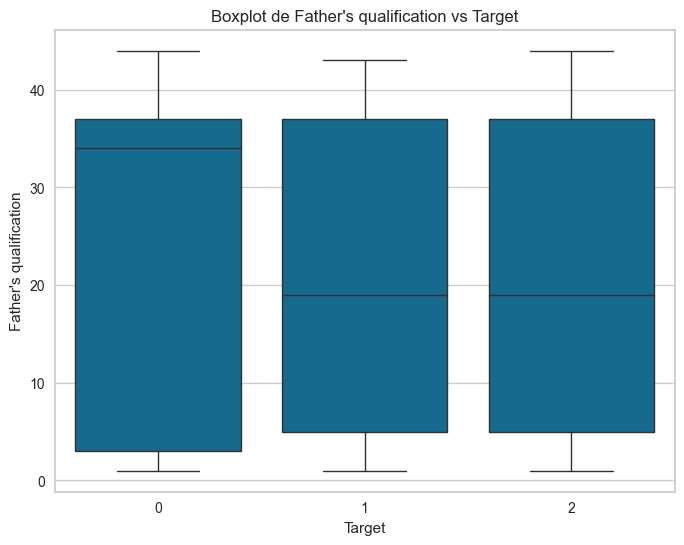

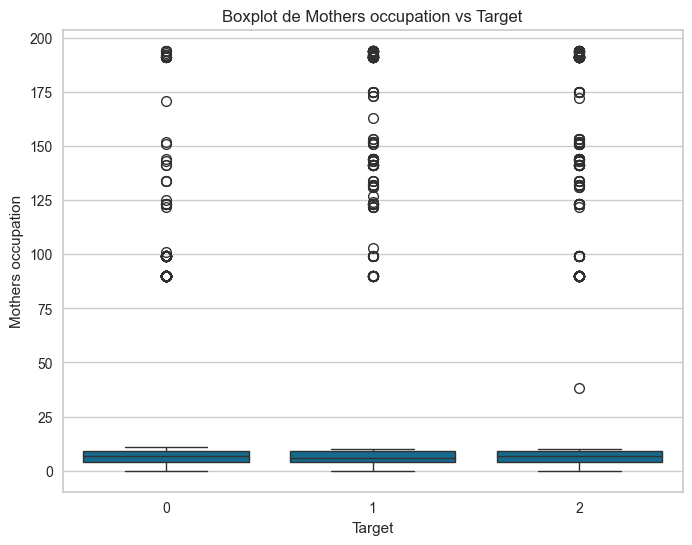

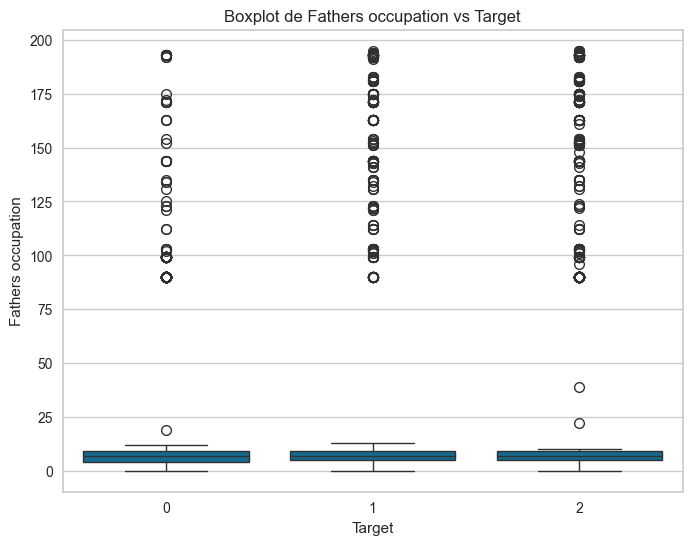

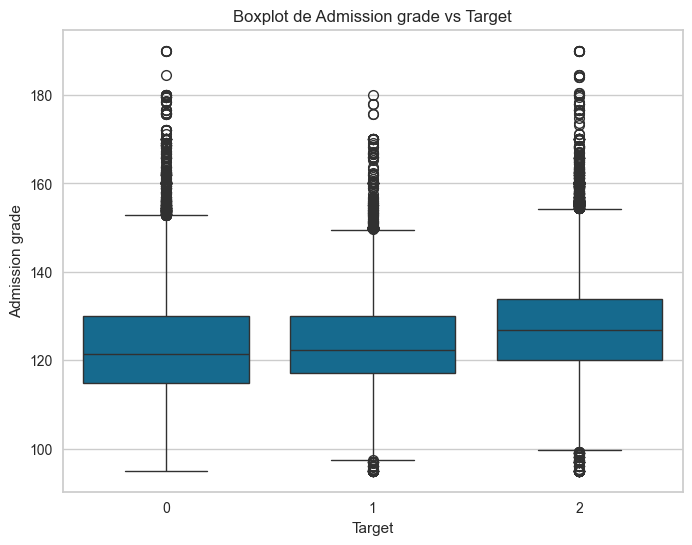

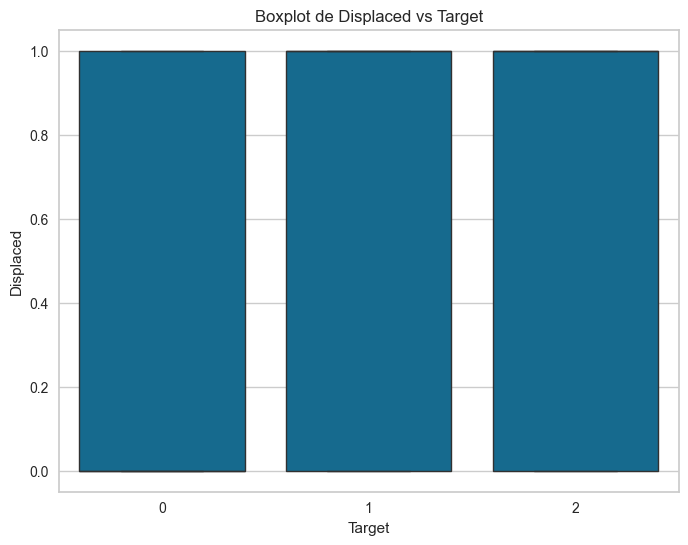

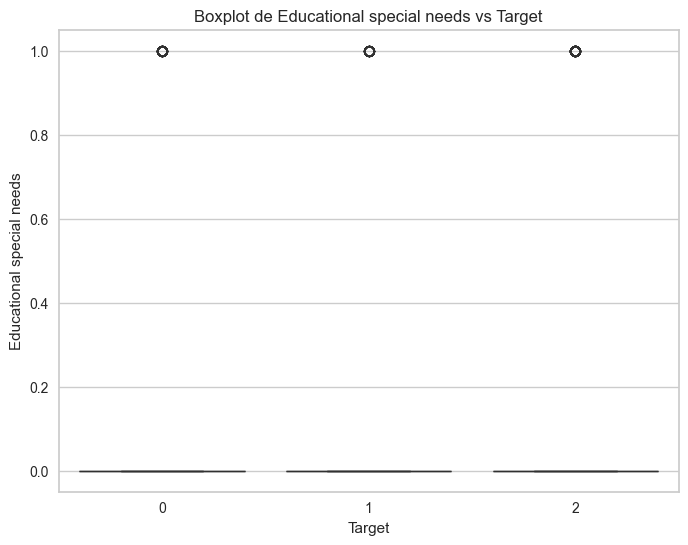

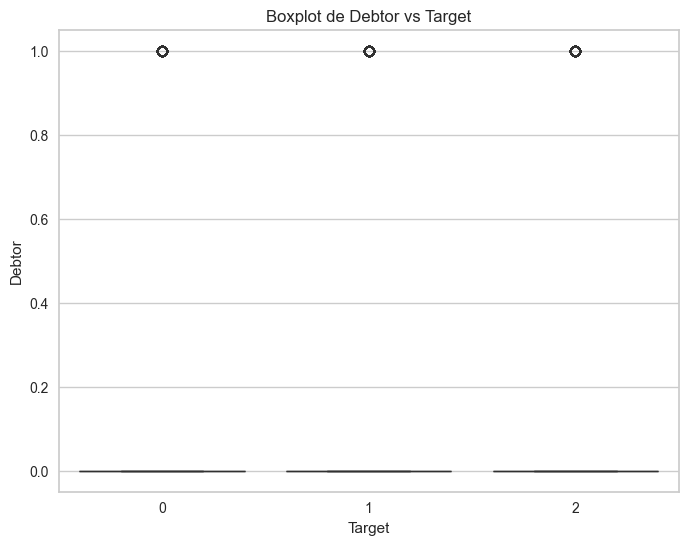

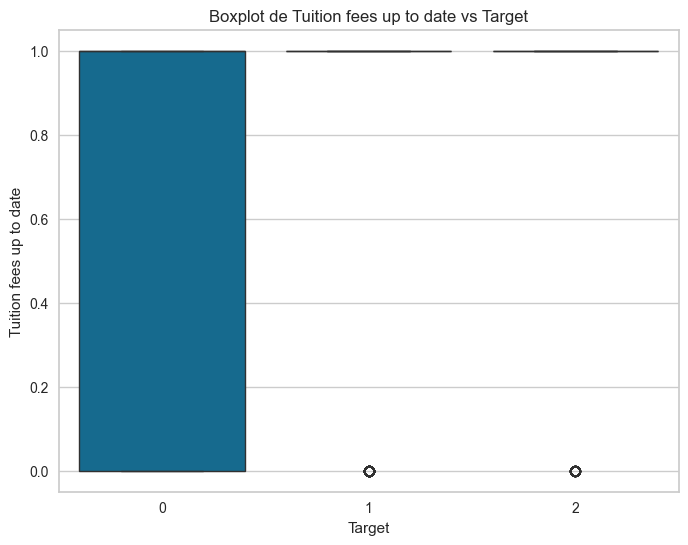

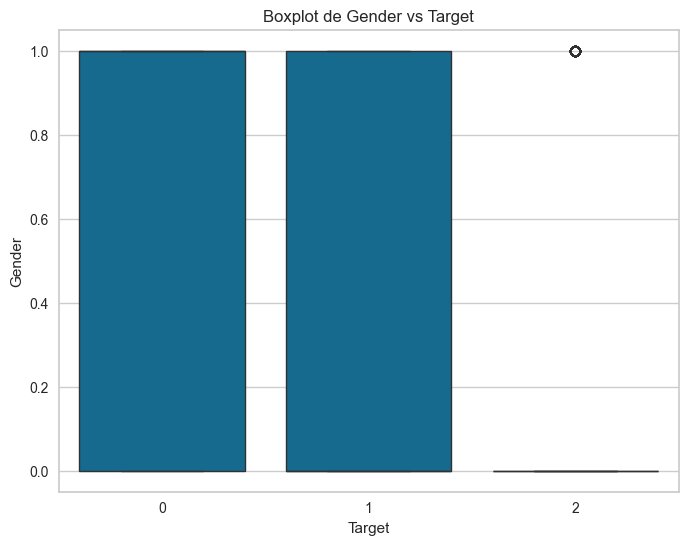

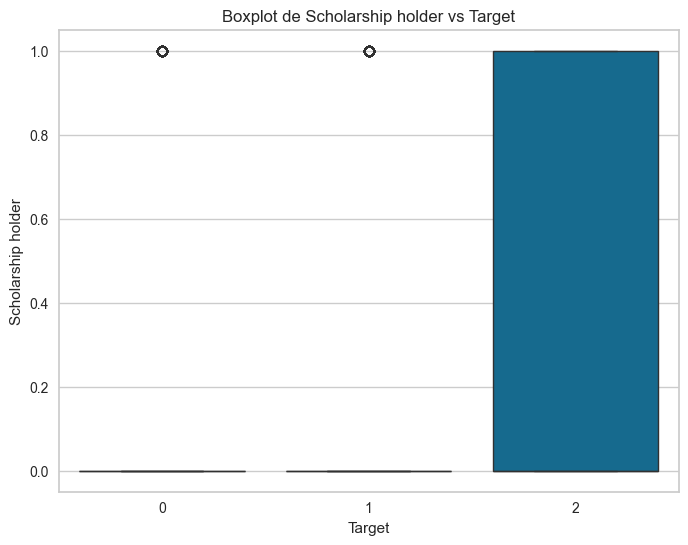

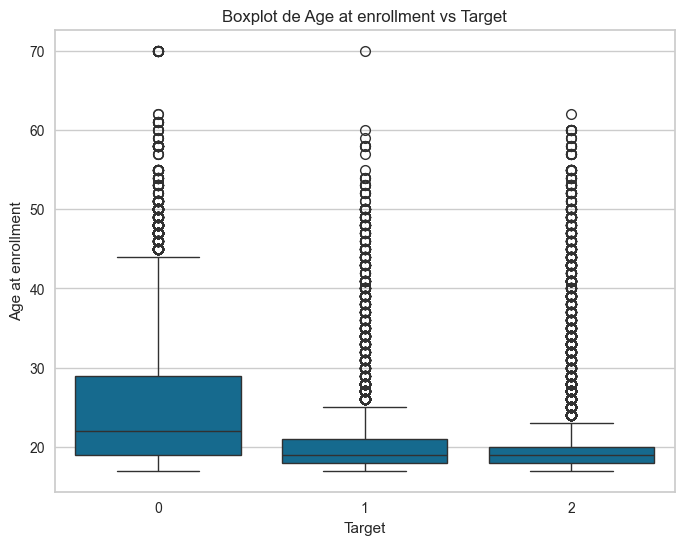

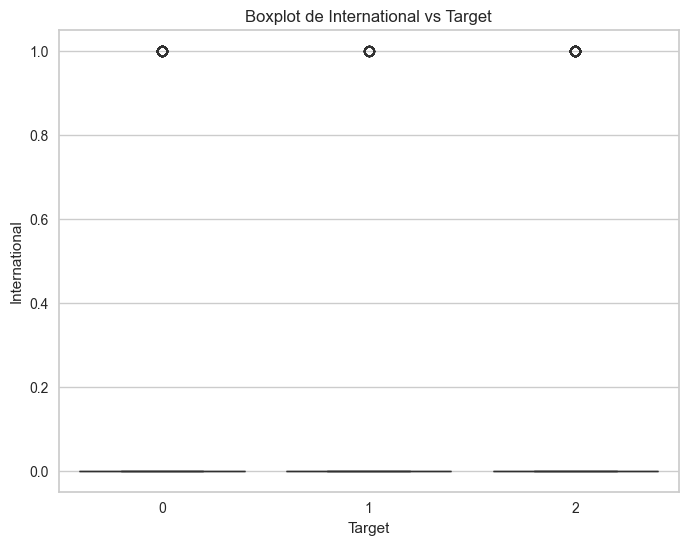

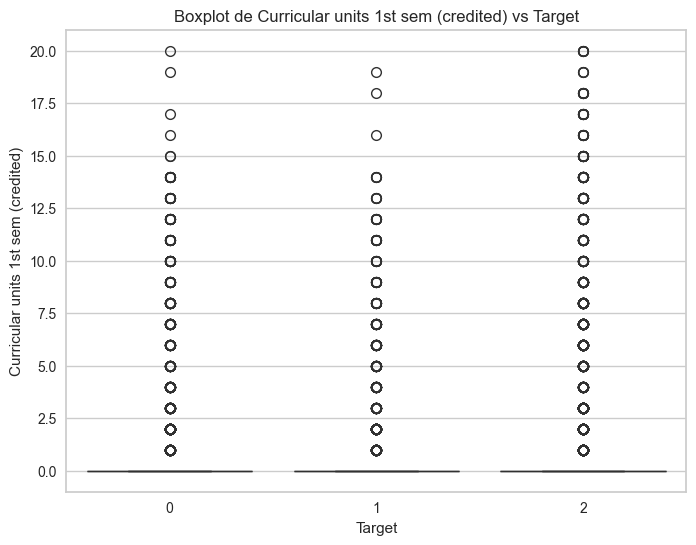

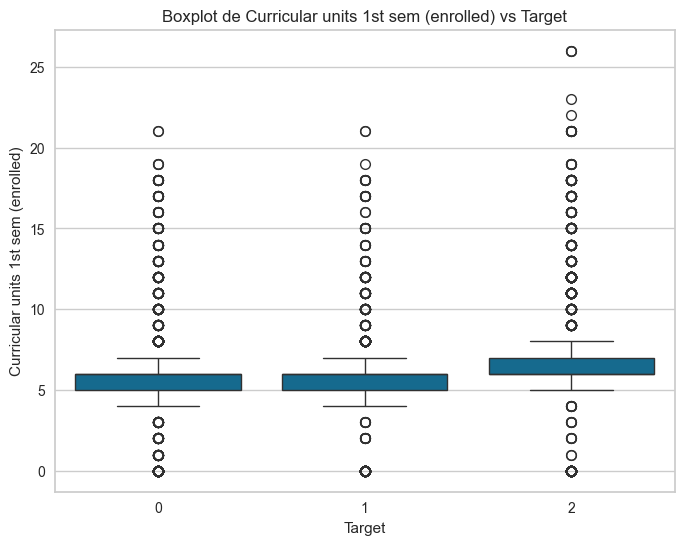

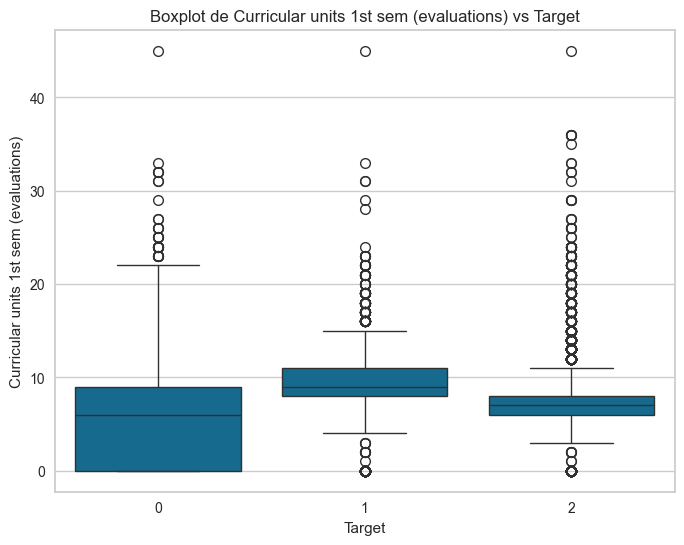

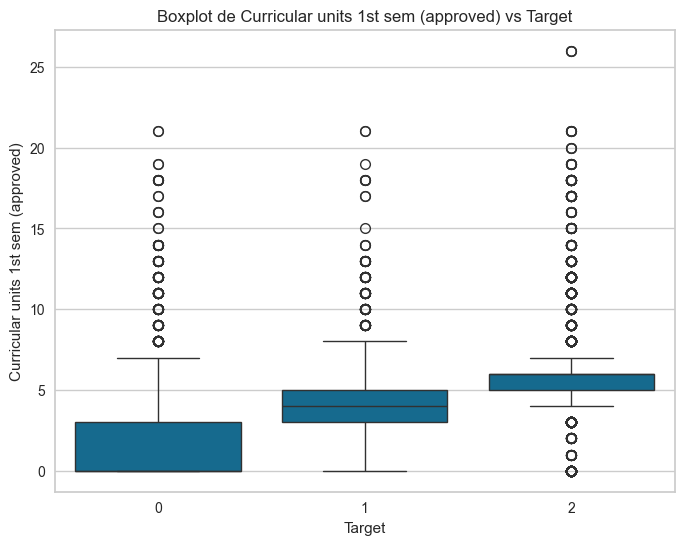

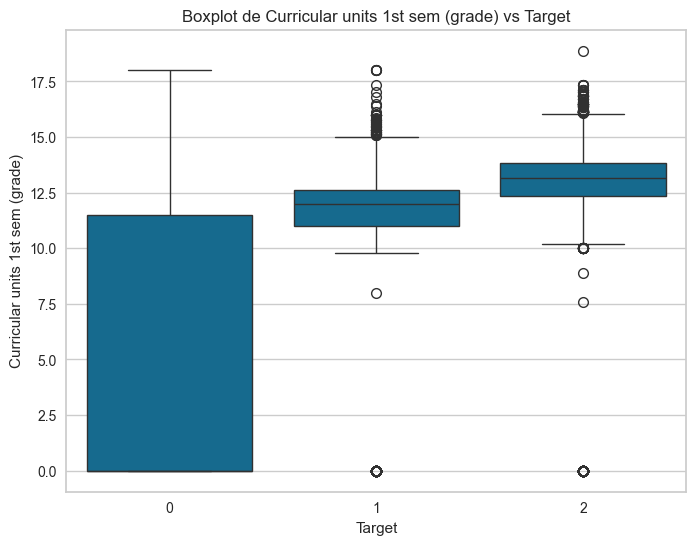

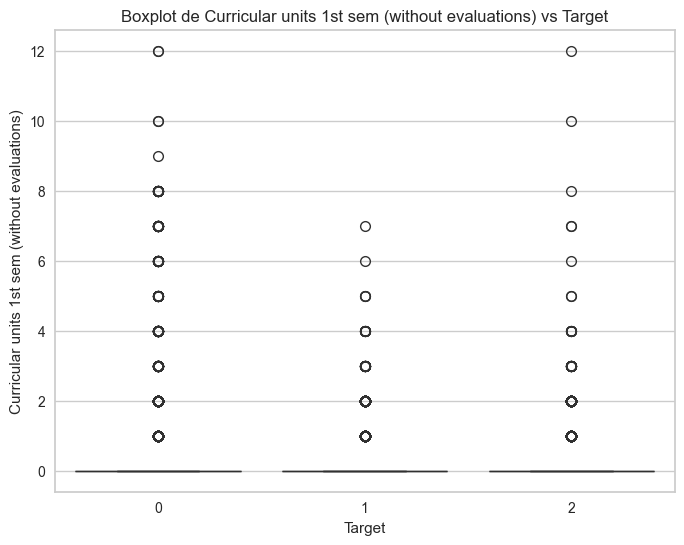

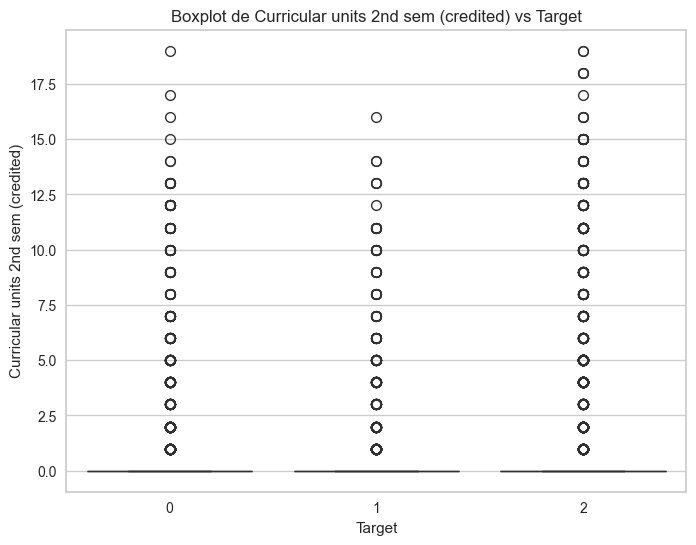

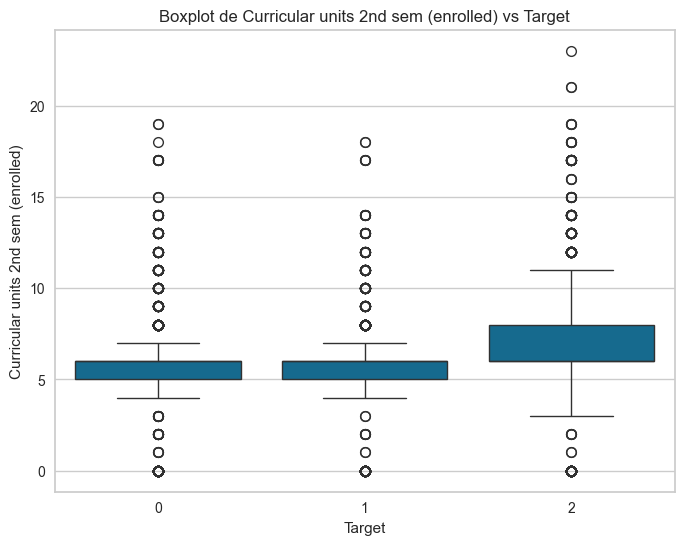

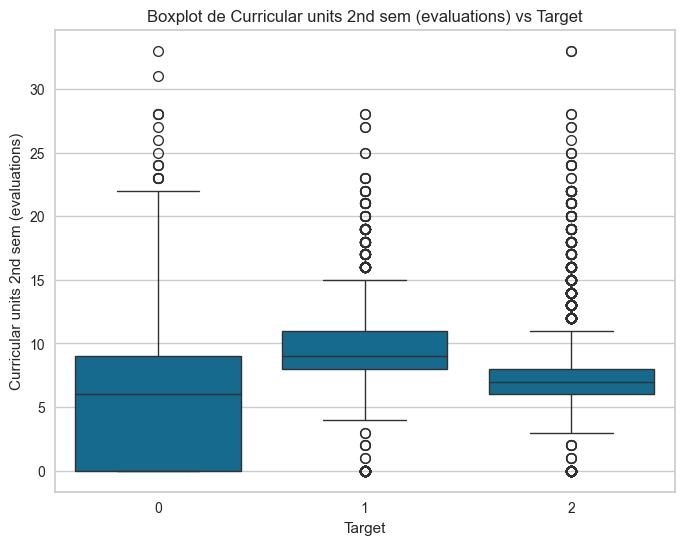

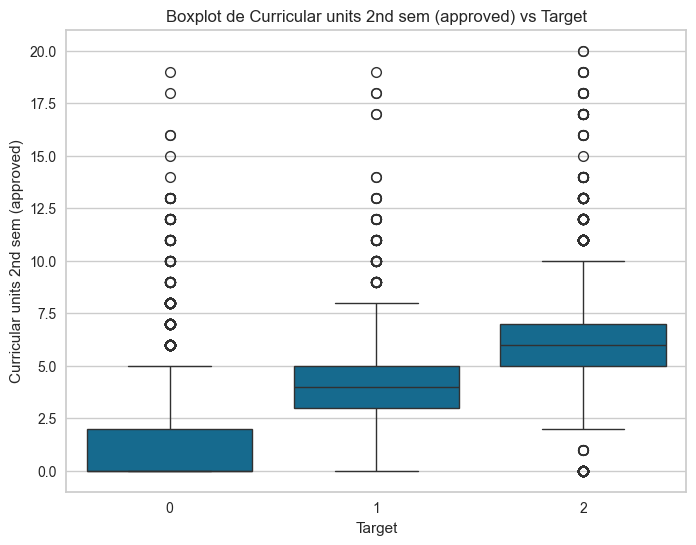

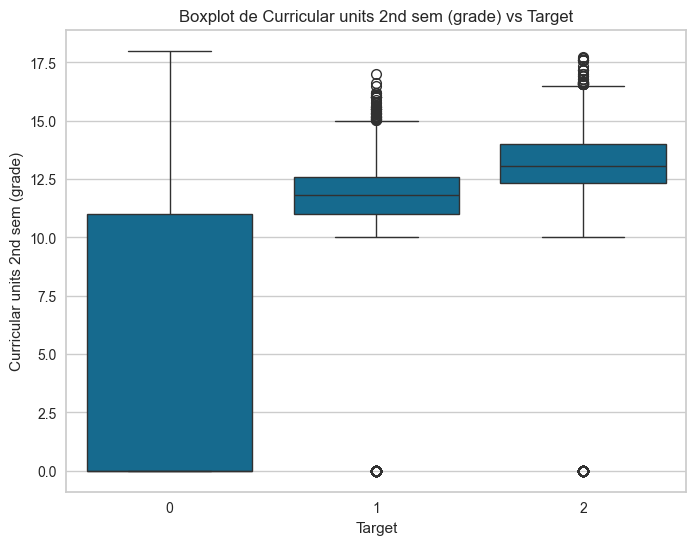

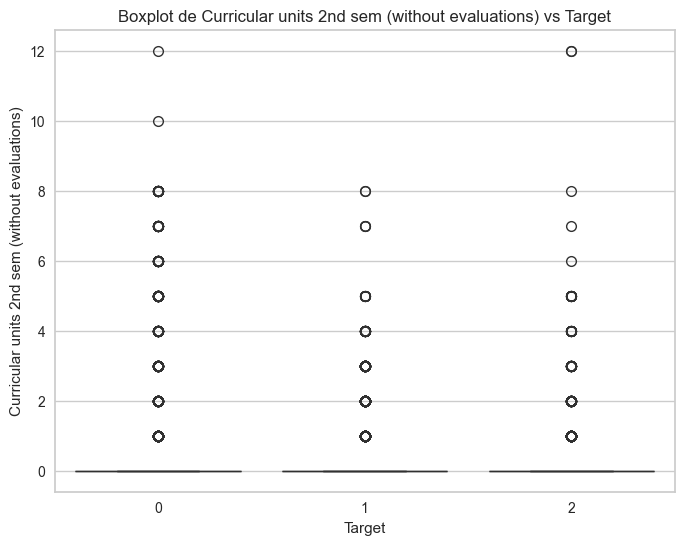

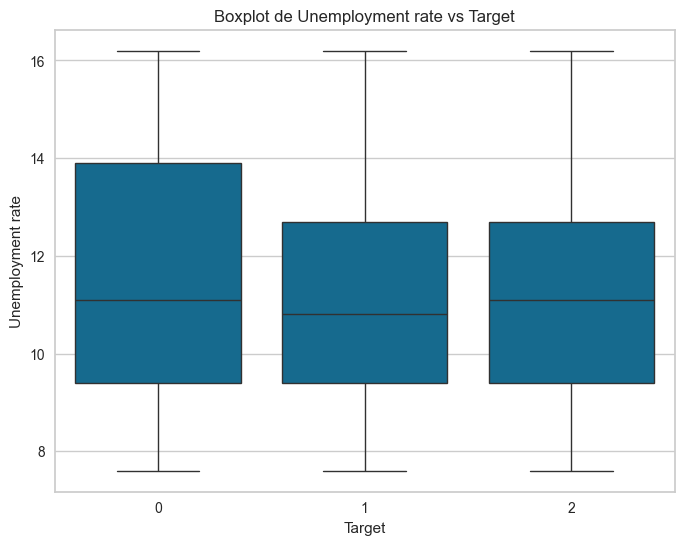

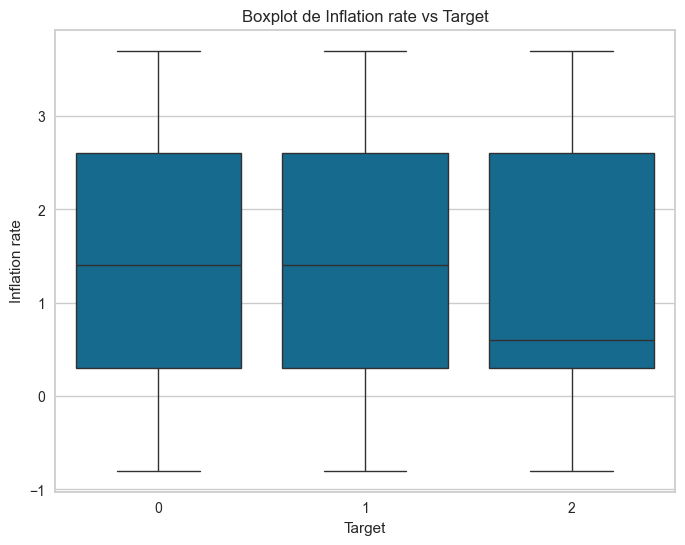

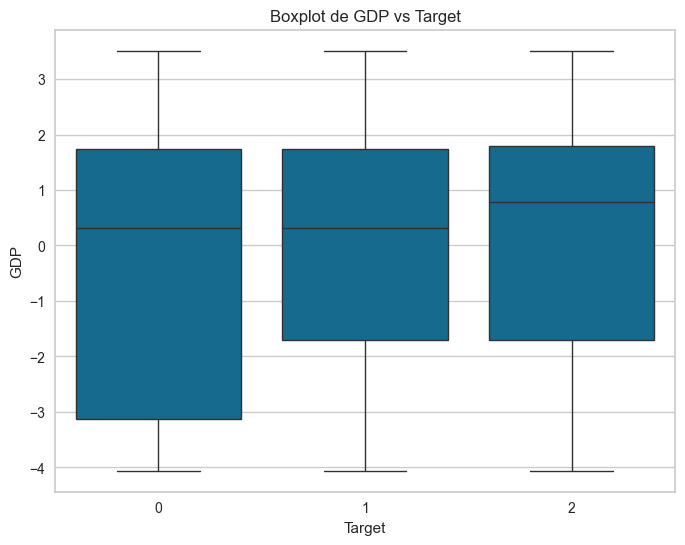

In [17]:
for k in numericas:
    plt.figure(figsize=(8,6))
    sns.boxplot(x="Target",y=k,data=df)
    plt.title("Boxplot de "+k+" vs Target")

In [45]:
def asociacion(data):
    categoricas=data.columns[data.dtypes=='object']
    V1=np.array(categoricas); V2=np.array(categoricas)
    grilla=np.meshgrid(V1,V2)
    grilla=pd.DataFrame({'Var1':grilla[0].ravel(),'Var2':grilla[1].ravel()})
    p_value=[stats.chi2_contingency(pd.DataFrame(pd.crosstab(data[grilla.iloc[x]['Var1']],data[grilla.iloc[x]['Var2']])))[1] for x in range(grilla.shape[0])]

    grilla['p_value']=p_value
    grilla2=grilla.pivot(index='Var1',columns='Var2',values='p_value')
    plt.figure(figsize=(10,8))
    gr=sns.heatmap(grilla2,linewidths=0.01,annot=True,fmt='.2f',cmap='summer')
    gr.set_title('Grilla de p valores en prueba chi cuadrado para verificar asociación entre variables')
    plt.xlabel(""); plt.ylabel(""); plt.yticks(rotation=0); plt.xticks(rotation=90)
    plt.show()
    return grilla,grilla2

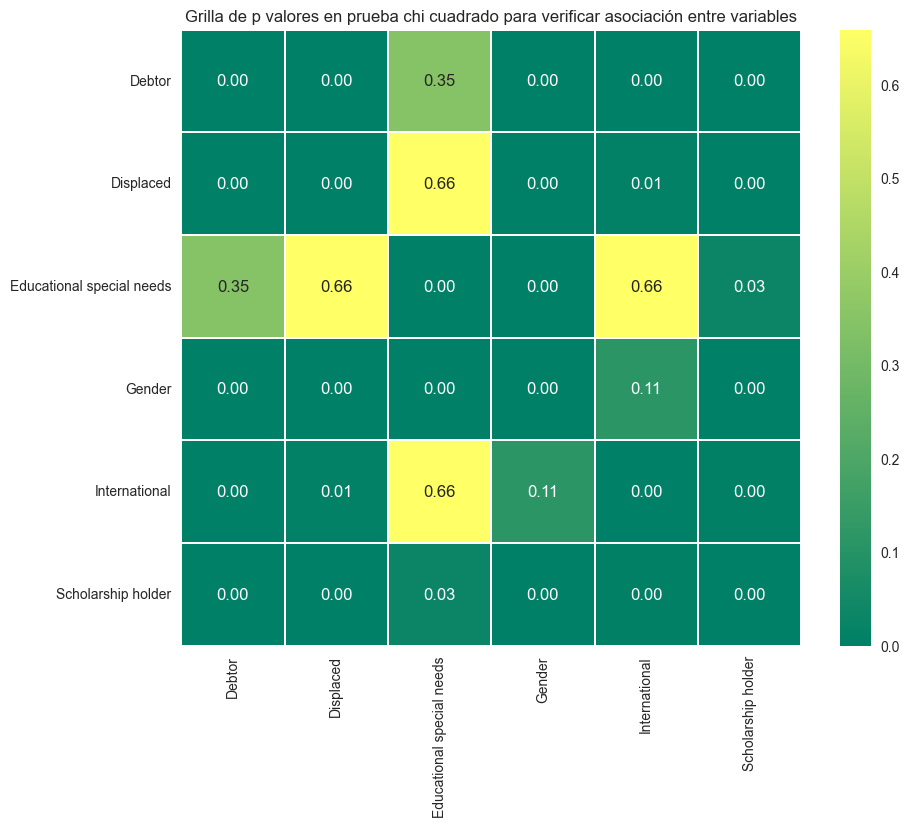

In [19]:
grilla_asociacion, grilla_asociacion2 = asociacion(df.drop(["id"],axis=1))

## Modelo sin ingenieria de variables

In [46]:
formato = pd.DataFrame(df.dtypes).reset_index()
formato.columns = ["Variable","Formato"]
categoricas = list(formato.loc[formato["Formato"] == "object",] ["Variable"])
categoricas = [x for x in categoricas if x not in ["Target"]]
numericas = list(formato.loc[formato["Formato"]!= "object",] ["Variable"])
numericas = [x for x in numericas if x not in ["Target", "id"]]
train_num = df.get(numericas)
train_cat = df.get(categoricas)

In [47]:
print(df.dtypes)

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mothers occupation                                  int64
Fathers occupation                                  int64
Admission grade                                   float64
Displaced                                          object
Educational special needs                          object
Debtor                                             object
Tuition fees u

In [48]:
exp_clf101 = setup(data=df, target='Target', session_id = 123, train_size=0.7,
numeric_features = numericas,
categorical_features = categoricas)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 38)"
4,Transformed data shape,"(76518, 38)"
5,Transformed train set shape,"(53562, 38)"
6,Transformed test set shape,"(22956, 38)"
7,Numeric features,30
8,Categorical features,6
9,Preprocess,True


## Eleccion del modelo

In [49]:
 %%time
# Comparar modelos ordenados por AUC
best_model = compare_models(include=['lightgbm', 'xgboost', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8303,0.9432,0.8303,0.8298,0.8287,0.7267,0.7282,2.1000
xgboost,Extreme Gradient Boosting,0.8296,0.9421,0.8296,0.8283,0.8278,0.7257,0.7269,1.2160
gbc,Gradient Boosting Classifier,0.8267,0.0000,0.8267,0.8259,0.8249,0.7207,0.7223,9.5900


CPU times: total: 6.59 s
Wall time: 2min 12s


### Modelo lightgbm

In [50]:
%%time
dt = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8357,0.9457,0.8357,0.8352,0.8345,0.7359,0.7370
1,0.8223,0.9417,0.8223,0.8203,0.8201,0.7136,0.7150
2,0.8198,0.9381,0.8198,0.8196,0.8183,0.7098,0.7113
3,0.8434,0.9484,0.8434,0.8441,0.8423,0.7480,0.7495
4,0.8282,0.9440,0.8282,0.8280,0.8270,0.7237,0.7249
5,0.8301,0.9410,0.8301,0.8267,0.8266,0.7251,0.7271
6,0.8301,0.9435,0.8301,0.8304,0.8289,0.7265,0.7280
7,0.8267,0.9426,0.8267,0.8275,0.8256,0.7211,0.7227
8,0.8333,0.9421,0.8333,0.8315,0.8312,0.7312,0.7326


CPU times: total: 5.95 s
Wall time: 14.7 s


In [51]:
hyperparameters = dt.get_params()
hyperparameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [52]:
import pickle
with open(path + 'best_model.pkl', 'wb') as model_file:
    pickle.dump(dt, model_file)

In [53]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt = tune_model(dt, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8280,0.9431,0.8280,0.8267,0.8265,0.7234,0.7244
1,0.8324,0.9434,0.8324,0.8313,0.8307,0.7301,0.7314
2,0.8290,0.9421,0.8290,0.8260,0.8261,0.7238,0.7254
3,0.8283,0.9428,0.8283,0.8277,0.8268,0.7235,0.7249
4,0.8334,0.9436,0.8334,0.8326,0.8320,0.7319,0.7331
Mean,0.8302,0.9430,0.8302,0.8289,0.8284,0.7266,0.7278
Std,0.0022,0.0005,0.0022,0.0026,0.0024,0.0037,0.0037


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 16.8 s
Wall time: 1min 16s


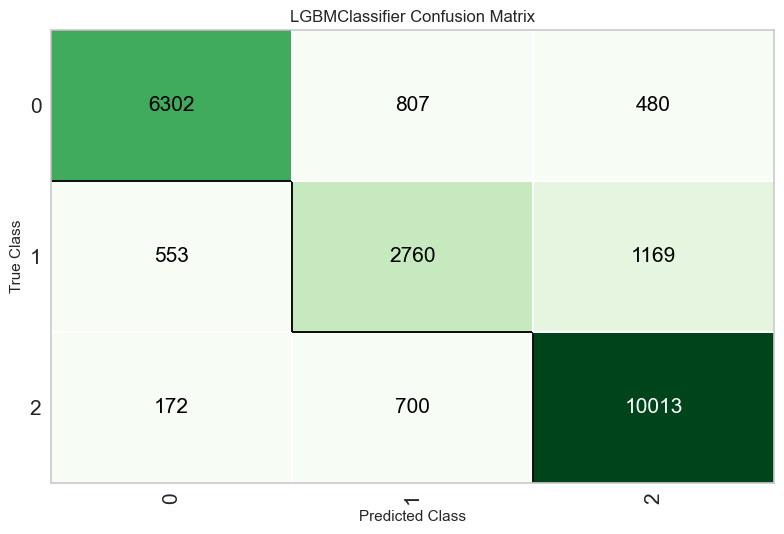

In [171]:
plot_model(tuned_dt, plot='confusion_matrix')

In [54]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [55]:
predictions_test = predict_model(tuned_dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8309,0.9443,0.8309,0.8299,0.8294,0.7280,0.7292


In [56]:
predictions_train = predict_model(tuned_dt, data=exp_clf101.get_config('X_train'))

In [57]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [58]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test["prediction_label"]))

0.8671446174526717
0.8309374455480049


In [59]:
%%time
# Finalizar el modelo
final_dt = finalize_model(tuned_dt)

CPU times: total: 15 s
Wall time: 4.9 s


### PREDICCION NUEVOS DATOS

In [60]:
# Variables cuantitativas (Activar D1)
D1 = prueba.get(numericas).copy()

# Variables categóricas
D2 = prueba.get(categoricas).copy()

# Columna 'id'
id_col = prueba['id'].copy()  

# Concatenar todas las variables
base_modelo2 = pd.concat([id_col, D1, D2], axis=1)

In [61]:
base_modelo2 = prueba

In [62]:
df_test = base_modelo2.copy()
column_types = df_test.dtypes
print(column_types)

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mothers occupation                                  int64
Fathers occupation                                  int64
Admission grade                                   float64
Displaced                                          object
Educational special needs                          object
Debtor                                             object
Tuition fees u

In [65]:
# Realizar predicciones
predictions = predict_model(final_dt, data=df_test)
predictions

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,prediction_label,prediction_score
0,76518,1,1,1,9500,1,1,141.000000,1,3,...,8,0,0,0.000000,0,13.9,-0.3,0.79,0,0.9938
1,76519,1,1,1,9238,1,1,128.000000,1,1,...,6,6,6,13.500000,0,11.1,0.6,2.02,2,0.9825
2,76520,1,1,1,9238,1,1,118.000000,1,1,...,6,11,5,11.000000,0,15.5,2.8,-4.06,2,0.7628
3,76521,1,44,1,9147,1,39,130.000000,1,1,...,8,14,5,11.000000,0,8.9,1.4,3.51,1,0.4848
4,76522,1,39,1,9670,1,1,110.000000,1,1,...,6,9,4,10.666667,2,7.6,2.6,0.32,1,0.6117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,127525,1,1,2,171,1,1,128.000000,1,38,...,0,0,0,0.000000,0,15.5,2.8,-4.06,0,0.8618
51008,127526,2,39,1,9119,1,19,133.100006,1,19,...,5,5,0,0.000000,0,9.4,-0.8,-3.12,0,0.9941
51009,127527,1,1,1,171,1,1,127.000000,1,1,...,0,0,0,0.000000,0,15.5,2.8,-4.06,0,0.9880
51010,127528,1,1,3,9773,1,1,132.000000,1,19,...,6,9,3,13.000000,0,7.6,2.6,0.32,0,0.9393


In [70]:
a_hat = final_dt.predict(prueba)
y_nuevo = prueba[]

In [182]:
predictions["prediction_label"].value_counts()

prediction_label
2    26557
0    15400
1     9055
Name: count, dtype: int64

In [183]:
# Asignar clases basadas en el score y la predicción original
def assign_class(row):
    if row["prediction_score"] < 0.9:
        return row["prediction_label"]  # Mantén la predicción original si el score es bajo
    else:
        return row["prediction_label"]  # Mantén la clase original si el score es alto

# Aplicar la función para crear la columna 'sc'
predictions["sc"] = predictions.apply(assign_class, axis=1)

#Verificar la distribución de clases en la columna 'sc'
print(predictions["sc"].value_counts())

sc
2.0    26557
0.0    15400
1.0     9055
Name: count, dtype: int64


In [184]:
#predictions["sc"] = predictions.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
#predictions["sc"].value_counts()

In [185]:
predictions.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,prediction_label,prediction_score,sc
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,0.0,0,13.9,-0.3,0.79,0,0.9938,0.0
1,76519,1,1,1,9238,1,1,128.0,1,1,...,6,6,13.5,0,11.1,0.6,2.02,2,0.9825,2.0


In [186]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions['sc']
})

result["Target"] = result["Target"].map(int)
result.head(5)

,id,Target
0,76518,0
1,76519,2
2,76520,2
3,76521,1
4,76522,1


In [187]:
result["Target"] = result["Target"].map({0.0 : 'Dropout', 1.0 : 'Enrolled', 2.0 : 'Graduate'})
result

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [188]:
result.to_csv(path + 'subbmision_albert.csv', index=False,sep=",")

In [189]:
# Guardar y cargar modelos
save_model(final_dt, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


### Modelo xgboost

In [190]:
%%time
modelo_2 = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8298,0.9456,0.8298,0.8296,0.8290,0.7270,0.7277
1,0.8256,0.9401,0.8256,0.8235,0.8236,0.7192,0.7203
2,0.8198,0.9373,0.8198,0.8182,0.8178,0.7096,0.7109
3,0.8406,0.9477,0.8406,0.8396,0.8389,0.7433,0.7446
4,0.8284,0.9423,0.8284,0.8268,0.8265,0.7236,0.7248
5,0.8308,0.9399,0.8308,0.8269,0.8273,0.7264,0.7282
6,0.8307,0.9430,0.8307,0.8298,0.8290,0.7272,0.7286
7,0.8215,0.9412,0.8215,0.8214,0.8203,0.7129,0.7142
8,0.8336,0.9410,0.8336,0.8317,0.8316,0.7320,0.7332


CPU times: total: 3.7 s
Wall time: 14.2 s


In [191]:
hyperparameters = modelo_2.get_params()
hyperparameters

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [192]:
with open(path + 'model_xgboost.pkl', 'wb') as model_file:
    pickle.dump(modelo_2, model_file)

In [193]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt2 = tune_model(modelo_2, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.9440,0.8284,0.8273,0.8269,0.7240,0.7251
1,0.8311,0.9436,0.8311,0.8309,0.8295,0.7278,0.7295
2,0.8299,0.9423,0.8299,0.8271,0.8270,0.7251,0.7269
3,0.8280,0.9425,0.8280,0.8286,0.8268,0.7231,0.7247
4,0.8337,0.9440,0.8337,0.8333,0.8323,0.7324,0.7337
Mean,0.8303,0.9433,0.8303,0.8294,0.8285,0.7265,0.7280
Std,0.0021,0.0007,0.0021,0.0024,0.0022,0.0033,0.0033


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 7.72 s
Wall time: 1min 19s


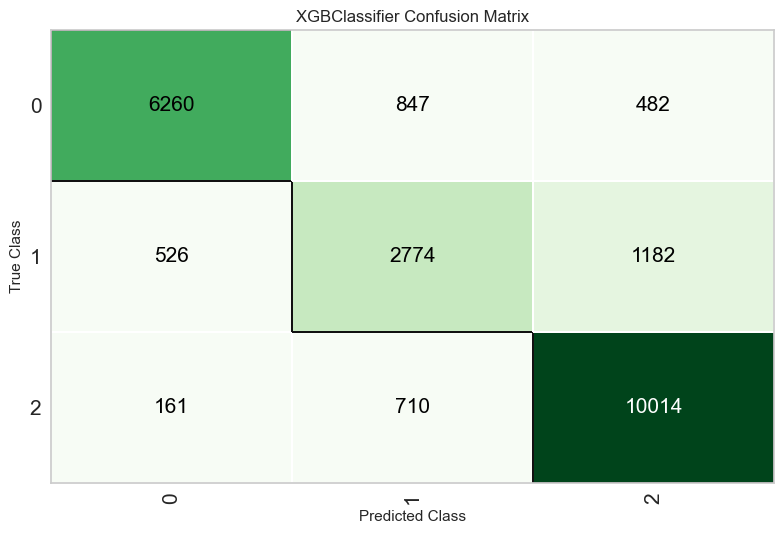

In [194]:
plot_model(tuned_dt2, plot='confusion_matrix')

In [195]:
evaluate_model(tuned_dt2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [196]:
predictions_test2 = predict_model(tuned_dt2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8298,0.9438,0.8298,0.8296,0.8285,0.7263,0.7275


In [197]:
predictions_train2 = predict_model(tuned_dt2, data=exp_clf101.get_config('X_train'))

In [198]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [199]:
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train2["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test2["prediction_label"]))

0.8391210186326127
0.8297612824533891


In [200]:
%%time
# Finalizar el modelo
final_dt2 = finalize_model(tuned_dt2)

CPU times: total: 6.12 s
Wall time: 3.3 s


In [201]:
predictions2 = predict_model(final_dt2, data=df_test)

In [202]:
predictions2["prediction_label"].value_counts()

prediction_label
2    26403
0    15210
1     9399
Name: count, dtype: int64

In [203]:
predictions2["sc"] = predictions.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
predictions2["sc"].value_counts()

sc
2    26122
1    22747
0     2143
Name: count, dtype: int64

In [204]:
predictions2.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,prediction_label,prediction_score,sc
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,0.0,0,13.9,-0.3,0.79,0,0.9962,2
1,76519,1,1,1,9238,1,1,128.0,1,1,...,6,6,13.5,0,11.1,0.6,2.02,2,0.9721,2


In [205]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result2 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions2['sc']
})

result2["Target"] = result2["Target"].map(int)
result2.head(5)

,id,Target
0,76518,2
1,76519,2
2,76520,1
3,76521,0
4,76522,1


In [206]:
result2["Target"] = result2["Target"].map({0 : 'Dropout', 1 : 'Enrolled', 2 : 'Graduate'})
result2

,id,Target
0,76518,Graduate
1,76519,Graduate
2,76520,Enrolled
3,76521,Dropout
4,76522,Enrolled
...,...,...
51007,127525,Enrolled
51008,127526,Graduate
51009,127527,Graduate
51010,127528,Graduate


In [207]:
result.to_csv(path + 'subbmision_albert.csv', index=False,sep=",")

In [208]:
save_model(final_dt, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [209]:
predictions_test2 = predict_model(tuned_dt2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8298,0.9438,0.8298,0.8296,0.8285,0.7263,0.7275


In [210]:
predictions_train2 = predict_model(tuned_dt2, data=exp_clf101.get_config('X_train'))

In [211]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [212]:
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train2["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test2["prediction_label"]))

0.8391210186326127
0.8297612824533891


In [213]:
%%time
# Finalizar el modelo
final_dt2 = finalize_model(tuned_dt2)

CPU times: total: 2.75 s
Wall time: 2.7 s


In [214]:
predictions2 = predict_model(final_dt2, data=df_test)

In [215]:
predictions2["prediction_label"].value_counts()

prediction_label
2    26403
0    15210
1     9399
Name: count, dtype: int64

In [216]:
predictions2["sc"] = predictions.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
predictions2["sc"].value_counts()

sc
2    26122
1    22747
0     2143
Name: count, dtype: int64

In [217]:
predictions2.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,prediction_label,prediction_score,sc
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,0.0,0,13.9,-0.3,0.79,0,0.9962,2
1,76519,1,1,1,9238,1,1,128.0,1,1,...,6,6,13.5,0,11.1,0.6,2.02,2,0.9721,2


In [218]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result2 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions2['sc']
})

result2["Target"] = result2["Target"].map(int)
result2.head(5)

,id,Target
0,76518,2
1,76519,2
2,76520,1
3,76521,0
4,76522,1


In [219]:
result2["Target"] = result2["Target"].map({0 : 'Dropout', 1 : 'Enrolled', 2 : 'Graduate'})
result2

,id,Target
0,76518,Graduate
1,76519,Graduate
2,76520,Enrolled
3,76521,Dropout
4,76522,Enrolled
...,...,...
51007,127525,Enrolled
51008,127526,Graduate
51009,127527,Graduate
51010,127528,Graduate


In [220]:
result.to_csv(path + 'subbmision_albert.csv', index=False,sep=",")

In [221]:
save_model(final_dt, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


## Con ingenieria de variables

### Variables al cuadrado

In [22]:
base_cuadrado = df.get(numericas).copy()
base_cuadrado["Target"] = df["Target"].copy()

var_names2, pvalue1 = [], []

for k in numericas:
    base_cuadrado[k+"_2"] = base_cuadrado[k] ** 2

    # Prueba de Kruskal sin logaritmo
    mue1 = base_cuadrado.loc[base_cuadrado["Target"]==0,k+"_2"].to_numpy()
    mue2 = base_cuadrado.loc[base_cuadrado["Target"]==1,k+"_2"].to_numpy()
    mue3 = base_cuadrado.loc[base_cuadrado["Target"]==2,k+"_2"].to_numpy()

    p1 = stats.kruskal(mue1,mue2, mue3)[1]

    # Guardar p values y variables
    var_names2.append(k+"_2")
    pvalue1.append(np.round(p1,2))

In [23]:
pcuadrado1 = pd.DataFrame({'Variable2':var_names2,'p value':pvalue1})
pcuadrado1["criterio"] = pcuadrado1.apply(lambda row: 1 if row["p value"]<=0.10 else 0,axis = 1)
pcuadrado1

,Variable2,p value,criterio
0,Marital status_2,0.00,1
1,Application mode_2,0.00,1
2,Application order_2,0.00,1
3,Course_2,0.00,1
4,Daytime/evening attendance_2,0.00,1
5,Previous qualification_2,0.00,1
6,Previous qualification (grade)_2,0.00,1
7,Nacionality_2,0.75,0
8,Mother's qualification_2,0.00,1
9,Father's qualification_2,0.00,1


### Interacciones cuantitativas

In [24]:
lista_inter = list(combinations(numericas,2))
base_interacciones = df.get(numericas).copy()
var_interaccion, pv1 = [], []
base_interacciones["Target"] = df["Target"].copy()

for k in lista_inter:
    base_interacciones[k[0]+"__"+k[1]] = base_interacciones[k[0]] * base_interacciones[k[1]]

    # Prueba de Kruskal
    mue1 = base_interacciones.loc[base_interacciones["Target"]==0,k[0]+"__"+k[1]].to_numpy()
    mue2 = base_interacciones.loc[base_interacciones["Target"]==1,k[0]+"__"+k[1]].to_numpy()
    mue3 = base_interacciones.loc[base_interacciones["Target"]==2,k[0]+"__"+k[1]].to_numpy()

    p1 = stats.kruskal(mue1,mue2, mue3)[1]

    var_interaccion.append(k[0]+"__"+k[1])
    pv1.append(np.round(p1,2))

In [25]:
pxy = pd.DataFrame({'Variable':var_interaccion,'p value':pv1})
pxy["criterio"] = pxy.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
pxy

,Variable,p value,criterio
0,Marital status__Application mode,0.0,1
1,Marital status__Application order,0.0,1
2,Marital status__Course,0.0,1
3,Marital status__Daytime/evening attendance,0.0,1
4,Marital status__Previous qualification,0.0,1
...,...,...,...
430,Curricular units 2nd sem (without evaluations)...,0.0,1
431,Curricular units 2nd sem (without evaluations)...,0.0,1
432,Unemployment rate__Inflation rate,0.0,1
433,Unemployment rate__GDP,0.0,1


### Razones

In [26]:
raz1 = [(x,y) for x in numericas for y in numericas]
base_razones1 = df.get(numericas).copy()
base_razones1["Target"] = df["Target"].copy()

var_nm, pval = [], []
for j in raz1:
    if j[0]!=j[1]:
        base_razones1[j[0]+"__coc__"+j[1]] = base_razones1[j[0]] / (base_razones1[j[1]]+0.01)

        # Prueba de Kruskal
        mue1 = base_razones1.loc[base_razones1["Target"]==0,j[0]+"__coc__"+j[1]].to_numpy()
        mue2 = base_razones1.loc[base_razones1["Target"]==1,j[0]+"__coc__"+j[1]].to_numpy()
        mue3 = base_razones1.loc[base_razones1["Target"]==2,j[0]+"__coc__"+j[1]].to_numpy()
        p1 = stats.kruskal(mue1,mue2, mue3)[1]
        
        # Guardar valores
        var_nm.append(j[0]+"__coc__"+j[1])
        pval.append(np.round(p1,2))

In [27]:
prazones = pd.DataFrame({'Variable':var_nm,'p value':pval})
prazones["criterio"] = prazones.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
prazones.head()

,Variable,p value,criterio
0,Marital status__coc__Application mode,0.0,1
1,Marital status__coc__Application order,0.0,1
2,Marital status__coc__Course,0.0,1
3,Marital status__coc__Daytime/evening attendance,0.0,1
4,Marital status__coc__Previous qualification,0.0,1


### Interacciones categóricas

In [28]:
categoricas = list(formato.loc[formato["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["id","Target"]]

def nombre_(x):
  return "C"+str(x)

In [29]:
cb = list(combinations(categoricas,2))
p_value, modalidades, nombre_var = [], [], []

base2 = df.get(categoricas).copy()
for k in base2.columns:
  base2[k] = base2[k].map(nombre_)

base2["Target"] = df["Target"].copy()

for k in range(len(cb)):
    # Variable con interacción
    base2[cb[k][0]] = base2[cb[k][0]]
    base2[cb[k][1]] = base2[cb[k][1]]

    base2[cb[k][0]+"__"+cb[k][1]] = base2[cb[k][0]] + "__" + base2[cb[k][1]]

    # Prueba chi cuadrado
    c1 = pd.DataFrame(pd.crosstab(base2["Target"],base2[cb[k][0]+"__"+cb[k][1]]))
    pv = stats.chi2_contingency(c1)[1]

    # Número de modalidades por categoría
    mod_ = len(base2[cb[k][0]+"__"+cb[k][1]].unique())

    # Guardar p value y modalidades
    nombre_var.append(cb[k][0]+"__"+cb[k][1])
    modalidades.append(mod_)
    p_value.append(pv)

In [30]:
pc = pd.DataFrame({'Variable':nombre_var,'Num Modalidades':modalidades,'p value':p_value})
pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),].sort_values(["p value"],ascending=True).head()

,Variable,Num Modalidades,p value
0,Displaced__Educational special needs,4,0.0
1,Displaced__Debtor,4,0.0
2,Displaced__Gender,4,0.0
3,Displaced__Scholarship holder,4,0.0
4,Displaced__International,4,0.0


In [31]:
def indicadora(x):
  if x==True:
    return 1
  else:
    return 0

seleccion1 = list(pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),"Variable"])
sel1 = base2.get(seleccion1)

contador = 0
for k in sel1:
    if contador==0:
        lb1 = pd.get_dummies(sel1[k],drop_first=True)
        lb1.columns = [k + "_" + x for x in lb1.columns]
    else:
        lb2 = pd.get_dummies(sel1[k],drop_first=True)
        lb2.columns = [k + "_" + x for x in lb2.columns]
        lb1 = pd.concat([lb1,lb2],axis=1)
    contador = contador + 1

for k in lb1.columns:
  lb1[k] = lb1[k].map(indicadora)

lb1["Target"] = df["Target"].copy()
lb1.head(3)

,Displaced__Educational special needs_C0__C1,Displaced__Educational special needs_C1__C0,Displaced__Educational special needs_C1__C1,Displaced__Debtor_C0__C1,Displaced__Debtor_C1__C0,Displaced__Debtor_C1__C1,Displaced__Gender_C0__C1,Displaced__Gender_C1__C0,Displaced__Gender_C1__C1,Displaced__Scholarship holder_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,2
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


## Interacción cuantitativa vs categórica

In [232]:
cat_cuanti = [(x,y) for x in numericas for y in categoricas]
cat_cuanti[0]

('Marital status', 'Displaced')

In [233]:
v1, v2, pvalores_min, pvalores_max  = [], [], [], []

for j in cat_cuanti:
    k1 = j[0]
    k2 = j[1]

    g1 = pd.get_dummies(df[k2])
    lt1 = list(g1.columns)

    for k in lt1:
        g1[k] = g1[k] * df[k1]

    g1["Target"] = df["Target"].copy()

    pvalues_c = []
    for y in lt1:
        mue1 = g1.loc[g1["Target"]==0,y].to_numpy()
        mue2 = g1.loc[g1["Target"]==1,y].to_numpy()
        mue3 = g1.loc[g1["Target"]==2,y].to_numpy()

        try:
          pval = (stats.kruskal(mue1,mue2)[1]<=0.20)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0
        pvalues_c.append(pval)

    min_ = np.min(pvalues_c) # Se revisa si alguna de las categorías no es significativa
    max_ = np.max(pvalues_c) # Se revisa si alguna de las categorías es significativa
    v1.append(k1) # nombre de la variable 1
    v2.append(k2) # nombre de la variable 2
    
    pvalores_min.append(np.round(min_,2))
    pvalores_max.append(np.round(max_,2))

In [234]:
pc2 = pd.DataFrame({'numerica':v1,'Categórica':v2,'p value':pvalores_min, 'p value max':pvalores_max})
pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),]

,numerica,Categórica,p value,p value max
0,Marital status,Displaced,1,1
2,Marital status,Debtor,1,1
3,Marital status,Gender,1,1
4,Marital status,Scholarship holder,1,1
6,Application mode,Displaced,1,1
...,...,...,...,...
172,Inflation rate,Scholarship holder,1,1
174,GDP,Displaced,1,1
177,GDP,Gender,1,1
178,GDP,Scholarship holder,1,1


## Base de Feature Enginnering

In [235]:
v1 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"numerica"])
v2 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Categórica"])

In [236]:
for j in range(len(v1)):

    if j==0:
        g1 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g1.columns)
        for k in lt1:
            g1[k] = g1[k] * df[v1[j]]
        g1.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
    else:
        g2 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g2.columns)
        for k in lt1:
            g2[k] = g2[k] * df[v1[j]]
        g2.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
        g1 = pd.concat([g1,g2],axis=1)

g1["Target"] = df["Target"].copy()
g1.head(5)

,Marital status_Displaced_1,Marital status_Debtor_1,Marital status_Gender_1,Marital status_Scholarship holder_1,Application mode_Displaced_1,Application mode_Debtor_1,Application mode_Gender_1,Application mode_Scholarship holder_1,Application order_Displaced_1,Application order_Debtor_1,...,Unemployment rate_Scholarship holder_1,Inflation rate_Displaced_1,Inflation rate_Debtor_1,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Gender_1,GDP_Scholarship holder_1,GDP_International_1,Target
0,0,0,0,1,0,0,0,1,0,0,...,11.1,0.0,0.0,0.0,0.6,0.00,0.00,2.02,0.0,2
1,1,0,0,0,17,0,0,0,1,0,...,0.0,0.6,0.0,0.0,0.0,2.02,0.00,0.00,0.0,0
2,0,0,1,0,0,0,17,0,0,0,...,0.0,0.0,0.0,0.3,0.0,-0.00,-0.92,-0.00,-0.0,0
3,1,0,0,1,1,0,0,1,3,0,...,11.1,0.6,0.0,0.0,0.6,2.02,0.00,2.02,0.0,1
4,1,0,0,0,1,0,0,0,2,0,...,0.0,2.6,0.0,0.0,0.0,0.32,0.00,0.00,0.0,2


## Selección de variables con XGBOOST

### variables al cuadrado

In [237]:
pcuadrado1.head()

,Variable2,p value,criterio
0,Marital status_2,0.0,1
1,Application mode_2,0.0,1
2,Application order_2,0.0,1
3,Course_2,0.0,1
4,Daytime/evening attendance_2,0.0,1


In [238]:
var_cuad = list(pcuadrado1["Variable2"])
base_modelo1 = base_cuadrado.get(var_cuad+["Target"])
base_modelo1["Target"] = base_modelo1["Target"].map(int)
base_modelo1.head()

,Marital status_2,Application mode_2,Application order_2,Course_2,Daytime/evening attendance_2,Previous qualification_2,Previous qualification (grade)_2,Nacionality_2,Mother's qualification_2,Father's qualification_2,...,Curricular units 2nd sem (credited)_2,Curricular units 2nd sem (enrolled)_2,Curricular units 2nd sem (evaluations)_2,Curricular units 2nd sem (approved)_2,Curricular units 2nd sem (grade)_2,Curricular units 2nd sem (without evaluations)_2,Unemployment rate_2,Inflation rate_2,GDP_2,Target
0,1,1,1,85340644,1,1,15876.0,1,1,361,...,0,36,49,36,154.469388,0,123.21,0.36,4.0804,2
1,1,289,1,85340644,1,1,15625.0,1,361,361,...,0,36,81,0,0.000000,0,123.21,0.36,4.0804,0
2,1,289,4,85636516,1,1,18769.0,1,9,361,...,0,36,0,0,0.000000,0,262.44,0.09,0.8464,0
3,1,1,9,90250000,1,1,17161.0,1,361,9,...,0,64,121,49,164.352400,0,123.21,0.36,4.0804,1
4,1,1,4,90250000,1,1,17424.0,1,361,1369,...,0,49,144,36,167.271111,0,57.76,6.76,0.1024,2


In [239]:
cov = list(base_modelo1.columns)
cov = [x for x in cov if x not in ["Target"]]

X1 = base_modelo1.get(cov)
y1 = base_modelo1.get(["Target"])

modelo1 = XGBClassifier()
modelo1 = modelo1.fit(X1,y1)

importancias = modelo1.feature_importances_
imp1 = pd.DataFrame({'Variable':X1.columns,'Importancia':importancias})
imp1["Importancia"] = imp1["Importancia"] * 100 / np.sum(imp1["Importancia"])
imp1 = imp1.sort_values(["Importancia"],ascending=False)
imp1.index = range(imp1.shape[0])
imp1.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)_2,53.875015
1,Tuition fees up to date_2,11.832299
2,Curricular units 2nd sem (enrolled)_2,4.694703
3,Curricular units 2nd sem (evaluations)_2,3.995911
4,Curricular units 1st sem (approved)_2,2.689609


### Interacciones cuantitativas

In [240]:
var_int = list(pxy["Variable"])
base_modelo2 = base_interacciones.get(var_int+["Target"])
base_modelo2["Target"] = base_modelo2["Target"].map(int)
base_modelo2.head()

,Marital status__Application mode,Marital status__Application order,Marital status__Course,Marital status__Daytime/evening attendance,Marital status__Previous qualification,Marital status__Previous qualification (grade),Marital status__Nacionality,Marital status__Mother's qualification,Marital status__Father's qualification,Marital status__Mothers occupation,...,Curricular units 2nd sem (grade)__Unemployment rate,Curricular units 2nd sem (grade)__Inflation rate,Curricular units 2nd sem (grade)__GDP,Curricular units 2nd sem (without evaluations)__Unemployment rate,Curricular units 2nd sem (without evaluations)__Inflation rate,Curricular units 2nd sem (without evaluations)__GDP,Unemployment rate__Inflation rate,Unemployment rate__GDP,Inflation rate__GDP,Target
0,1,1,9238,1,1,126.0,1,1,19,5,...,137.957143,7.457143,25.105714,0.0,0.0,0.0,6.66,22.422,1.212,2
1,17,1,9238,1,1,125.0,1,19,19,9,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.66,22.422,1.212,0
2,17,2,9254,1,1,137.0,1,3,19,2,...,0.000000,0.000000,-0.000000,0.0,0.0,-0.0,4.86,-14.904,-0.276,0
3,1,3,9500,1,1,131.0,1,19,3,3,...,142.302000,7.692000,25.896400,0.0,0.0,0.0,6.66,22.422,1.212,1
4,1,2,9500,1,1,132.0,1,19,37,4,...,98.293333,33.626667,4.138667,0.0,0.0,0.0,19.76,2.432,0.832,2


In [241]:
cov = list(base_modelo2.columns)
cov = [x for x in cov if x not in ["Target"]]

X2 = base_modelo2.get(cov)
y2 = base_modelo2.get(["Target"])

modelo2 = XGBClassifier()
modelo2 = modelo2.fit(X2,y2)

importancias = modelo2.feature_importances_
imp2 = pd.DataFrame({'Variable':X2.columns,'Importancia':importancias})
imp2["Importancia"] = imp2["Importancia"] * 100 / np.sum(imp2["Importancia"])
imp2 = imp2.sort_values(["Importancia"],ascending=False)
imp2.index = range(imp2.shape[0])
imp2.head()

,Variable,Importancia
0,Tuition fees up to date__Curricular units 2nd ...,55.660328
1,Curricular units 1st sem (evaluations)__Curric...,2.694397
2,Curricular units 1st sem (approved)__Curricula...,2.256166
3,Tuition fees up to date__Curricular units 2nd ...,1.027887
4,Curricular units 1st sem (grade)__Curricular u...,1.018415


### Razones

In [242]:
var_raz = list(prazones["Variable"])
base_modelo3 = base_razones1.get(var_raz+["Target"])
base_modelo3["Target"] = base_modelo3["Target"].map(int)
base_modelo3.head()

,Marital status__coc__Application mode,Marital status__coc__Application order,Marital status__coc__Course,Marital status__coc__Daytime/evening attendance,Marital status__coc__Previous qualification,Marital status__coc__Previous qualification (grade),Marital status__coc__Nacionality,Marital status__coc__Mother's qualification,Marital status__coc__Father's qualification,Marital status__coc__Mothers occupation,...,GDP__coc__Curricular units 1st sem (without evaluations),GDP__coc__Curricular units 2nd sem (credited),GDP__coc__Curricular units 2nd sem (enrolled),GDP__coc__Curricular units 2nd sem (evaluations),GDP__coc__Curricular units 2nd sem (approved),GDP__coc__Curricular units 2nd sem (grade),GDP__coc__Curricular units 2nd sem (without evaluations),GDP__coc__Unemployment rate,GDP__coc__Inflation rate,Target
0,0.990099,0.990099,0.000108,0.990099,0.990099,0.007936,0.990099,0.990099,0.052604,0.199601,...,202.0,202.0,0.336106,0.288160,0.336106,0.162398,202.0,0.181818,3.311475,2
1,0.058789,0.990099,0.000108,0.990099,0.990099,0.007999,0.990099,0.052604,0.052604,0.110988,...,202.0,202.0,0.336106,0.224195,202.000000,202.000000,202.0,0.181818,3.311475,0
2,0.058789,0.497512,0.000108,0.990099,0.990099,0.007299,0.990099,0.332226,0.052604,0.497512,...,-92.0,-92.0,-0.153078,-92.000000,-92.000000,-92.000000,-92.0,-0.056755,-2.967742,0
3,0.990099,0.332226,0.000105,0.990099,0.990099,0.007633,0.990099,0.052604,0.332226,0.332226,...,202.0,202.0,0.252185,0.183470,0.288160,0.157443,202.0,0.181818,3.311475,1
4,0.990099,0.497512,0.000105,0.990099,0.990099,0.007575,0.990099,0.052604,0.027020,0.249377,...,32.0,32.0,0.045649,0.026644,0.053245,0.024723,32.0,0.042050,0.122605,2


In [243]:
cov = list(base_modelo3.columns)
cov = [x for x in cov if x not in ["Target"]]

X3 = base_modelo3.get(cov)
y3 = base_modelo3.get(["Target"])

modelo3 = XGBClassifier()
modelo3 = modelo3.fit(X3,y3)

importancias = modelo3.feature_importances_
imp3 = pd.DataFrame({'Variable':X3.columns,'Importancia':importancias})
imp3["Importancia"] = imp3["Importancia"] * 100 / np.sum(imp3["Importancia"])
imp3 = imp3.sort_values(["Importancia"],ascending=False)
imp3.index = range(imp3.shape[0])
imp3.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)__coc__Curr...,17.253422
1,Curricular units 2nd sem (approved)__coc__Curr...,14.039166
2,Curricular units 2nd sem (approved)__coc__Age ...,5.779965
3,Tuition fees up to date__coc__Curricular units...,5.490637
4,Age at enrollment__coc__Curricular units 2nd s...,4.975932


### Interacciones categoricas

In [244]:
lb1["Target"] = lb1["Target"].map(int)
lb1.head()

,Displaced__Educational special needs_C0__C1,Displaced__Educational special needs_C1__C0,Displaced__Educational special needs_C1__C1,Displaced__Debtor_C0__C1,Displaced__Debtor_C1__C0,Displaced__Debtor_C1__C1,Displaced__Gender_C0__C1,Displaced__Gender_C1__C0,Displaced__Gender_C1__C1,Displaced__Scholarship holder_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,2
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


In [245]:
cov = list(lb1.columns)
cov = [x for x in cov if x not in ["Target"]]

X4 = lb1.get(cov)
y4 = lb1.get(["Target"])

modelo4 = XGBClassifier()
modelo4 = modelo4.fit(X4,y4)

importancias = modelo4.feature_importances_
imp4 = pd.DataFrame({'Variable':X4.columns,'Importancia':importancias})
imp4["Importancia"] = imp4["Importancia"] * 100 / np.sum(imp4["Importancia"])
imp4 = imp4.sort_values(["Importancia"],ascending=False)
imp4.index = range(imp4.shape[0])
imp4.head(5)

,Variable,Importancia
0,Debtor__Scholarship holder_C0__C1,42.000790
1,Gender__Scholarship holder_C1__C0,18.623419
2,Debtor__Scholarship holder_C1__C0,15.492254
3,Educational special needs__Gender_C0__C1,13.173891
4,Educational special needs__Scholarship holder_...,5.154407


### interaccion cuantitativa - categorica

In [246]:
g1["Target"] = g1["Target"].map(int)
g1.head()

,Marital status_Displaced_1,Marital status_Debtor_1,Marital status_Gender_1,Marital status_Scholarship holder_1,Application mode_Displaced_1,Application mode_Debtor_1,Application mode_Gender_1,Application mode_Scholarship holder_1,Application order_Displaced_1,Application order_Debtor_1,...,Unemployment rate_Scholarship holder_1,Inflation rate_Displaced_1,Inflation rate_Debtor_1,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Gender_1,GDP_Scholarship holder_1,GDP_International_1,Target
0,0,0,0,1,0,0,0,1,0,0,...,11.1,0.0,0.0,0.0,0.6,0.00,0.00,2.02,0.0,2
1,1,0,0,0,17,0,0,0,1,0,...,0.0,0.6,0.0,0.0,0.0,2.02,0.00,0.00,0.0,0
2,0,0,1,0,0,0,17,0,0,0,...,0.0,0.0,0.0,0.3,0.0,-0.00,-0.92,-0.00,-0.0,0
3,1,0,0,1,1,0,0,1,3,0,...,11.1,0.6,0.0,0.0,0.6,2.02,0.00,2.02,0.0,1
4,1,0,0,0,1,0,0,0,2,0,...,0.0,2.6,0.0,0.0,0.0,0.32,0.00,0.00,0.0,2


In [247]:
cov = list(g1.columns)
cov = [x for x in cov if x not in ["Target"]]

X5 = g1.get(cov)
y5 = g1.get(["Target"])

modelo5 = XGBClassifier(objective="multi:softmax", num_class=3)
modelo5 = modelo5.fit(X5,y5)

importancias = modelo5.feature_importances_
imp5 = pd.DataFrame({'Variable':X5.columns,'Importancia':importancias})
imp5["Importancia"] = imp5["Importancia"] * 100 / np.sum(imp5["Importancia"])
imp5 = imp5.sort_values(["Importancia"],ascending=False)
imp5.index = range(imp5.shape[0])
imp5.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)_Scholarshi...,14.280571
1,Curricular units 2nd sem (approved)_Displaced_1,13.776028
2,Marital status_Gender_1,11.937725
3,Marital status_Debtor_1,6.351748
4,Curricular units 2nd sem (approved)_Gender_1,4.950727
5,Marital status_Displaced_1,4.185294
6,Curricular units 2nd sem (enrolled)_Displaced_1,2.614479
7,Curricular units 1st sem (enrolled)_Gender_1,2.465398
8,Tuition fees up to date_Gender_1,2.282657
9,Tuition fees up to date_Displaced_1,2.193671


## Variable mas importantes por XGBOOST en cada caso

In [248]:
c2 = list(imp1.iloc[0:3,0]) # Variables al cuadrado
c2

['Curricular units 2nd sem (approved)_2',
 'Tuition fees up to date_2',
 'Curricular units 2nd sem (enrolled)_2']

In [114]:
razxy = list(imp3.iloc[0:3,0]) # Razones
razxy

['Curricular units 2nd sem (approved)__coc__Curricular units 1st sem (enrolled)',
 'Curricular units 2nd sem (approved)__coc__Curricular units 2nd sem (enrolled)',
 'Tuition fees up to date__coc__Curricular units 1st sem (without evaluations)']

In [115]:
cxy = list(imp2.iloc[0:3,0]) # Interacciones cuantitativas
cxy

['Tuition fees up to date__Curricular units 2nd sem (approved)',
 'Curricular units 1st sem (evaluations)__Curricular units 2nd sem (evaluations)',
 'Curricular units 1st sem (approved)__Curricular units 2nd sem (approved)']

In [116]:
catxy = list(imp4.iloc[0:3,0]) # Interacciones categóricas
catxy

['Debtor__Scholarship holder_C0__C1',
 'Gender__Scholarship holder_C1__C0',
 'Debtor__Scholarship holder_C1__C0']

In [117]:
cuactxy = list(imp5.iloc[0:3,0]) # Interacción cuantitativa y categórica
cuactxy

['Curricular units 2nd sem (approved)_Scholarship holder_1',
 'Curricular units 2nd sem (approved)_Displaced_1',
 'Curricular units 2nd sem (approved)_Gender_1']

## Preparacion de datos

In [118]:
# Variables cuantitativas (Activar D1)
D1 = df.get(numericas).copy()

# Variables categóricas
D2 = df.get(categoricas).copy()
for k in categoricas:
    D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
    D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
    D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
    k2 = k[0]
    D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
    D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]


In [119]:
base_modelo = pd.concat([D1,D4],axis=1)
base_modelo["Target"] = df["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(int)
base_modelo.head(3)

,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Tuition fees up to date,...,Fathers occupation,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,International,Debtor__Scholarship holder,Gender__Scholarship holder,Target
0,1,1,9238,1,1,126.0,1,19,122.6,1,...,C5,C0,C0,C0,C0,C1,C0,C0_C1,C0_C1,2
1,17,1,9238,1,1,125.0,19,19,119.8,1,...,C9,C1,C0,C0,C0,C0,C0,C0_C0,C0_C0,0
2,17,2,9254,1,1,137.0,3,19,144.7,1,...,C3,C0,C0,C0,C1,C0,C0,C0_C0,C1_C0,0


In [120]:
formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable","Formato"]
cuantitativas_bm = list(formatos.loc[formatos["Formato"]!="object",]["Variable"])
categoricas_bm = list(formatos.loc[formatos["Formato"]=="object",]["Variable"])
cuantitativas_bm = [x for x in cuantitativas_bm if x not in ["Target"]]
categoricas_bm = [x for x in categoricas_bm if x not in ["Target"]]

In [121]:
# Configuración del experimento
exp_clf101 = setup(data=base_modelo,
target='Target',
session_id=123,
train_size=0.7,
numeric_features = cuantitativas_bm,
categorical_features = categoricas_bm)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 48)"
4,Transformed data shape,"(76518, 75)"
5,Transformed train set shape,"(53562, 75)"
6,Transformed test set shape,"(22956, 75)"
7,Numeric features,35
8,Categorical features,12
9,Preprocess,True


In [122]:
%%time
# Comparar modelos ordenados por AUC
best_model = compare_models(include=['lightgbm', 'xgboost', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8296,0.9422,0.8296,0.8278,0.8276,0.7255,0.7267,1.7760
lightgbm,Light Gradient Boosting Machine,0.8293,0.9430,0.8293,0.8286,0.8277,0.7251,0.7265,2.7250
gbc,Gradient Boosting Classifier,0.8278,0.0000,0.8278,0.8263,0.8256,0.7223,0.7239,12.1870


CPU times: total: 9.55 s
Wall time: 2min 52s


In [123]:
%%time
modelo_3 = create_model('lightgbm')  # lightgbm
# dt = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8363,0.9463,0.8363,0.8360,0.8351,0.7369,0.7380
1,0.8227,0.9412,0.8227,0.8211,0.8206,0.7142,0.7156
2,0.8181,0.9375,0.8181,0.8174,0.8165,0.7070,0.7084
3,0.8413,0.9485,0.8413,0.8417,0.8403,0.7448,0.7461
4,0.8254,0.9434,0.8254,0.8240,0.8236,0.7188,0.7201
5,0.8294,0.9414,0.8294,0.8264,0.8262,0.7241,0.7260
6,0.8295,0.9427,0.8295,0.8297,0.8283,0.7256,0.7271
7,0.8251,0.9422,0.8251,0.8257,0.8241,0.7186,0.7200
8,0.8314,0.9421,0.8314,0.8296,0.8295,0.7285,0.7296


CPU times: total: 7.31 s
Wall time: 28.6 s


In [124]:
hyperparameters = modelo_3.get_params()
hyperparameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [125]:
with open(path + 'modelo_3.pkl', 'wb') as model_file:
    pickle.dump(dt, model_file)

In [126]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt3 = tune_model(modelo_3, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8281,0.9439,0.8281,0.8261,0.8261,0.7232,0.7243
1,0.8304,0.9430,0.8304,0.8287,0.8285,0.7268,0.7280
2,0.8302,0.9428,0.8302,0.8270,0.8272,0.7257,0.7273
3,0.8302,0.9429,0.8302,0.8293,0.8285,0.7265,0.7278
4,0.8360,0.9438,0.8360,0.8349,0.8344,0.7359,0.7372
Mean,0.8310,0.9433,0.8310,0.8292,0.8289,0.7276,0.7289
Std,0.0026,0.0005,0.0026,0.0031,0.0029,0.0044,0.0043


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 22.9 s
Wall time: 2min 26s


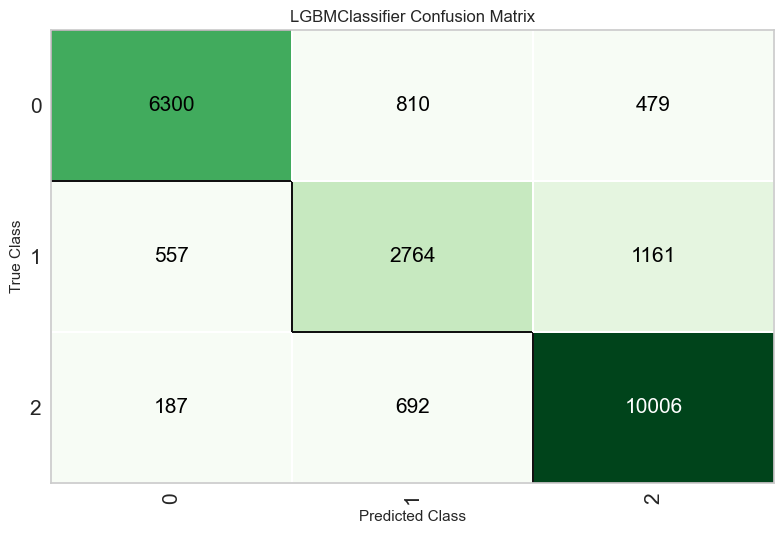

In [127]:
plot_model(tuned_dt3, plot='confusion_matrix')

In [128]:
evaluate_model(tuned_dt3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [129]:
predictions_test3 = predict_model(tuned_dt3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8307,0.9444,0.8307,0.8296,0.8292,0.7277,0.7288


In [130]:
predictions_train3 = predict_model(tuned_dt3, data=exp_clf101.get_config('X_train'))

In [131]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [132]:
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train3["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test3["prediction_label"]))

0.8664538292072738
0.8307196375675204


In [133]:
%%time
# Finalizar el modelo
final_dt3 = finalize_model(tuned_dt3)

CPU times: total: 11.9 s
Wall time: 4.72 s


In [134]:
# Variables cuantitativas (Activar D1)
D1 = prueba.get(numericas).copy()

# Variables categóricas
D2 = prueba.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]


In [135]:
base_modelo2 = pd.concat([D1,D4],axis=1)
base_modelo2.head(3)

,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Tuition fees up to date,...,Mothers occupation,Fathers occupation,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,International,Debtor__Scholarship holder,Gender__Scholarship holder
0,1,1,9500,1,1,141.0,3,1,152.1,0,...,C2,C3,C0,C0,C0,C0,C0,C0,C0_C0,C0_C0
1,1,1,9238,1,1,128.0,1,19,116.5,1,...,C4,C5,C0,C0,C0,C0,C0,C0,C0_C0,C0_C0
2,1,1,9238,1,1,118.0,1,19,114.2,1,...,C4,C9,C0,C0,C0,C0,C1,C0,C0_C1,C0_C1


In [136]:
df_test3 = base_modelo2.copy()
column_types = df_test.dtypes
print(column_types)

id                                                  int64
Marital status                                     object
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                        object
Mother's qualification                              int64
Father's qualification                              int64
Mothers occupation                                 object
Fathers occupation                                 object
Admission grade                                   float64
Displaced                                          object
Educational special needs                          object
Debtor                                             object
Tuition fees u

In [137]:
# Realizar predicciones
predictions3 = predict_model(final_dt3, data=df_test3)

In [138]:
predictions3["prediction_label"].value_counts()

prediction_label
2    26404
0    15303
1     9305
Name: count, dtype: int64

In [139]:
predictions3["sc"] = predictions.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
predictions3["sc"].value_counts()

sc
2    26377
1    22497
0     2138
Name: count, dtype: int64

In [140]:
predictions3.head()

,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Tuition fees up to date,...,Educational special needs,Debtor,Gender,Scholarship holder,International,Debtor__Scholarship holder,Gender__Scholarship holder,prediction_label,prediction_score,sc
0,1,1,9500,1,1,141.0,3,1,152.100006,0,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,0,0.9956,2
1,1,1,9238,1,1,128.0,1,19,116.500000,1,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,2,0.9906,2
2,1,1,9238,1,1,118.0,1,19,114.199997,1,...,C0,C0,C0,C1,C0,C0_C1,C0_C1,2,0.7171,1
3,44,1,9147,1,39,130.0,1,19,130.000000,1,...,C0,C0,C0,C1,C0,C0_C1,C0_C1,2,0.4318,0
4,39,1,9670,1,1,110.0,1,37,106.000000,1,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,1,0.5675,1


In [141]:
result3 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions['sc']
})

result3["Target"] = result3["Target"].map(int)
result3.head(5)

,id,Target
0,76518,0
1,76519,2
2,76520,2
3,76521,1
4,76522,1


In [142]:
result3["Target"] = result3["Target"].map({0 : 'Dropout', 1 : 'Enrolled', 2 : 'Graduate'})
result3

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [143]:
result3.to_csv(path + 'predicciones_ingvariables.csv', index=False,sep=",")

### MODELO XGBOOST

In [144]:
modelo_4 = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.9455,0.8333,0.8320,0.8319,0.7322,0.7330
1,0.8225,0.9398,0.8225,0.8193,0.8198,0.7137,0.7149
2,0.8198,0.9360,0.8198,0.8178,0.8175,0.7092,0.7107
3,0.8406,0.9477,0.8406,0.8399,0.8393,0.7436,0.7447
4,0.8292,0.9420,0.8292,0.8270,0.8270,0.7247,0.7259
5,0.8282,0.9399,0.8282,0.8240,0.8246,0.7223,0.7239
6,0.8318,0.9435,0.8318,0.8302,0.8296,0.7287,0.7302
7,0.8254,0.9408,0.8254,0.8245,0.8240,0.7192,0.7203
8,0.8295,0.9415,0.8295,0.8270,0.8273,0.7254,0.7264


In [145]:
hyperparameters = modelo_4.get_params()
hyperparameters

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [146]:
with open(path + 'modelo_4.pkl', 'wb') as model_file:
    pickle.dump(dt, model_file)

In [147]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt4 = tune_model(modelo_4, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8288,0.9435,0.8288,0.8272,0.8270,0.7245,0.7256
1,0.8304,0.9425,0.8304,0.8292,0.8287,0.7268,0.7281
2,0.8302,0.9419,0.8302,0.8266,0.8269,0.7255,0.7272
3,0.8272,0.9421,0.8272,0.8265,0.8256,0.7216,0.7231
4,0.8364,0.9434,0.8364,0.8353,0.8348,0.7367,0.7379
Mean,0.8306,0.9427,0.8306,0.8290,0.8286,0.7270,0.7284
Std,0.0031,0.0007,0.0031,0.0033,0.0033,0.0051,0.0051


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 14.2 s
Wall time: 2min


In [148]:
predictions_test4 = predict_model(tuned_dt4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8316,0.9442,0.8316,0.8307,0.8301,0.7291,0.7302


In [149]:
predictions_train4 = predict_model(tuned_dt4, data=exp_clf101.get_config('X_train'))

In [192]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [193]:
print(accuracy_score(y_train,predictions_train4["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test4["prediction_label"]))

0.8659684104402375
0.831590869489458


In [194]:
%%time
# Finalizar el modelo
final_dt4 = finalize_model(tuned_dt4)

CPU times: total: 13.6 s
Wall time: 7.78 s


In [196]:
base_modelo2 = pd.concat([D1,D4],axis=1)
base_modelo2.head(3)

,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Tuition fees up to date,...,Marital status,Nacionality,Mothers occupation,Fathers occupation,Displaced,Educational special needs,Debtor,Gender,Scholarship holder,International
0,1,1,9500,1,1,141.0,3,1,152.1,0,...,C1,C1,C2,C3,C0,C0,C0,C0,C0,C0
1,1,1,9238,1,1,128.0,1,19,116.5,1,...,C1,C1,C4,C5,C0,C0,C0,C0,C0,C0
2,1,1,9238,1,1,118.0,1,19,114.2,1,...,C1,C1,C4,C9,C0,C0,C0,C0,C1,C0


In [197]:
df_test4 = base_modelo2.copy()
column_types = df_test4.dtypes
print(column_types)

Application mode                                                                    int64
Application order                                                                   int64
Course                                                                              int64
Daytime/evening attendance                                                          int64
Previous qualification                                                              int64
Previous qualification (grade)                                                    float64
Mother's qualification                                                              int64
Father's qualification                                                              int64
Admission grade                                                                   float64
Tuition fees up to date                                                             int64
Age at enrollment                                                                   int64
Curricular

In [198]:
# Realizar predicciones
predictions4 = predict_model(final_dt4, data=df_test4)

KeyError: "['Debtor__Scholarship holder', 'Gender__Scholarship holder'] not in index"

In [ ]:
predictions4["prediction_label"].value_counts()

In [ ]:
predictions4["sc"] = predictions.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
predictions4["sc"].value_counts()

In [ ]:
result4 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions['sc']
})

result4["Target"] = result4["Target"].map(int)
result4.head(5)

In [ ]:
result4["Target"] = result4["Target"].map({0 : 'Dropout', 1 : 'Enrolled', 2 : 'Graduate'})
result4

In [ ]:
result4.to_csv(path + 'predicciones_ingvariables2.csv', index=False,sep=",")

In [4]:
df = pd.read_csv(path  + 'train.csv')
prueba = pd.read_csv(path + "test.csv")

df["Target"] = df["Target"].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})
ct = ['Gender', 'Displaced', 'Educational special needs', 'Debtor', 'Scholarship holder', 
  'International']

for k in ct:
    df[k] = df[k].astype("object")
    prueba[k] = prueba[k].astype("object")
    
formato = pd.DataFrame(df.dtypes).reset_index()
formato.columns = ["Variable","Formato"]
categoricas = list(formato.loc[formato["Formato"] == "object",] ["Variable"])
categoricas = [x for x in categoricas if x not in ["Target"]]
numericas = list(formato.loc[formato["Formato"]!= "object",] ["Variable"])
numericas = [x for x in numericas if x not in ["Target", "id"]]

# Variables al cuadrado 
base_cuadrado = df.get(numericas).copy()
base_cuadrado["Target"] = df["Target"].copy()

var_names2, pvalue1 = [], []

for k in numericas:
    base_cuadrado[k+"_2"] = base_cuadrado[k] ** 2

    # Prueba de Kruskal sin logaritmo
    mue1 = base_cuadrado.loc[base_cuadrado["Target"]==0,k+"_2"].to_numpy()
    mue2 = base_cuadrado.loc[base_cuadrado["Target"]==1,k+"_2"].to_numpy()
    mue3 = base_cuadrado.loc[base_cuadrado["Target"]==2,k+"_2"].to_numpy()

    p1 = stats.kruskal(mue1,mue2, mue3)[1]

    # Guardar p values y variables
    var_names2.append(k+"_2")
    pvalue1.append(np.round(p1,2))


pcuadrado1 = pd.DataFrame({'Variable2':var_names2,'p value':pvalue1})
pcuadrado1["criterio"] = pcuadrado1.apply(lambda row: 1 if row["p value"]<=0.10 else 0,axis = 1)

# interacciones cuantitavias
lista_inter = list(combinations(numericas,2))
base_interacciones = df.get(numericas).copy()
var_interaccion, pv1 = [], []
base_interacciones["Target"] = df["Target"].copy()

for k in lista_inter:
    base_interacciones[k[0]+"__"+k[1]] = base_interacciones[k[0]] * base_interacciones[k[1]]

    # Prueba de Kruskal
    mue1 = base_interacciones.loc[base_interacciones["Target"]==0,k[0]+"__"+k[1]].to_numpy()
    mue2 = base_interacciones.loc[base_interacciones["Target"]==1,k[0]+"__"+k[1]].to_numpy()
    mue3 = base_interacciones.loc[base_interacciones["Target"]==2,k[0]+"__"+k[1]].to_numpy()

    p1 = stats.kruskal(mue1,mue2, mue3)[1]

    var_interaccion.append(k[0]+"__"+k[1])
    pv1.append(np.round(p1,2))

pxy = pd.DataFrame({'Variable':var_interaccion,'p value':pv1})
pxy["criterio"] = pxy.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)

# Razones

raz1 = [(x,y) for x in numericas for y in numericas]
base_razones1 = df.get(numericas).copy()
base_razones1["Target"] = df["Target"].copy()

var_nm, pval = [], []
for j in raz1:
    if j[0]!=j[1]:
        base_razones1[j[0]+"__coc__"+j[1]] = base_razones1[j[0]] / (base_razones1[j[1]]+0.01)

    # Prueba de Kruskal
        mue1 = base_razones1.loc[base_razones1["Target"]==0,j[0]+"__coc__"+j[1]].to_numpy()
        mue2 = base_razones1.loc[base_razones1["Target"]==1,j[0]+"__coc__"+j[1]].to_numpy()
        mue3 = base_razones1.loc[base_razones1["Target"]==2,j[0]+"__coc__"+j[1]].to_numpy()
        p1 = stats.kruskal(mue1,mue2, mue3)[1]
    
    # Guardar valores
        var_nm.append(j[0]+"__coc__"+j[1])
        pval.append(np.round(p1,2))

prazones = pd.DataFrame({'Variable':var_nm,'p value':pval})
prazones["criterio"] = prazones.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)

# interacciones categoricas

categoricas = list(formato.loc[formato["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["id","Target"]]

def nombre_(x):
  return "C"+str(x)
    
cb = list(combinations(categoricas,2))
p_value, modalidades, nombre_var = [], [], []

base2 = df.get(categoricas).copy()
for k in base2.columns:
    base2[k] = base2[k].map(nombre_)

base2["Target"] = df["Target"].copy()

for k in range(len(cb)):
# Variable con interacción
    base2[cb[k][0]] = base2[cb[k][0]]
    base2[cb[k][1]] = base2[cb[k][1]]

    base2[cb[k][0]+"__"+cb[k][1]] = base2[cb[k][0]] + "__" + base2[cb[k][1]]

# Prueba chi cuadrado
    c1 = pd.DataFrame(pd.crosstab(base2["Target"],base2[cb[k][0]+"__"+cb[k][1]]))
    pv = stats.chi2_contingency(c1)[1]

# Número de modalidades por categoría
    mod_ = len(base2[cb[k][0]+"__"+cb[k][1]].unique())

# Guardar p value y modalidades
    nombre_var.append(cb[k][0]+"__"+cb[k][1])
    modalidades.append(mod_)
    p_value.append(pv)

pc = pd.DataFrame({'Variable':nombre_var,'Num Modalidades':modalidades,'p value':p_value})
pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),].sort_values(["p value"],ascending=True).head()

def indicadora(x):
  if x==True:
    return 1
  else:
    return 0

seleccion1 = list(pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),"Variable"])
sel1 = base2.get(seleccion1)

contador = 0
for k in sel1:
    if contador==0:
        lb1 = pd.get_dummies(sel1[k],drop_first=True)
        lb1.columns = [k + "_" + x for x in lb1.columns]
    else:
        lb2 = pd.get_dummies(sel1[k],drop_first=True)
        lb2.columns = [k + "_" + x for x in lb2.columns]
        lb1 = pd.concat([lb1,lb2],axis=1)
    contador = contador + 1

for k in lb1.columns:
  lb1[k] = lb1[k].map(indicadora)

lb1["Target"] = df["Target"].copy()
lb1.head(3)

cat_cuanti = [(x,y) for x in numericas for y in categoricas]

v1, v2, pvalores_min, pvalores_max  = [], [], [], []

for j in cat_cuanti:
    k1 = j[0]
    k2 = j[1]

    g1 = pd.get_dummies(df[k2])
    lt1 = list(g1.columns)

    for k in lt1:
        g1[k] = g1[k] * df[k1]

    g1["Target"] = df["Target"].copy()

    pvalues_c = []
    for y in lt1:
        mue1 = g1.loc[g1["Target"]==0,y].to_numpy()
        mue2 = g1.loc[g1["Target"]==1,y].to_numpy()
        mue3 = g1.loc[g1["Target"]==2,y].to_numpy()

        try:
          pval = (stats.kruskal(mue1,mue2)[1]<=0.20)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0
        pvalues_c.append(pval)

    min_ = np.min(pvalues_c) # Se revisa si alguna de las categorías no es significativa
    max_ = np.max(pvalues_c) # Se revisa si alguna de las categorías es significativa
    v1.append(k1) # nombre de la variable 1
    v2.append(k2) # nombre de la variable 2
    
    pvalores_min.append(np.round(min_,2))
    pvalores_max.append(np.round(max_,2))

pc2 = pd.DataFrame({'numerica':v1,'Categórica':v2,'p value':pvalores_min, 'p value max':pvalores_max})
pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),]

v1 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"numerica"])
v2 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Categórica"])

for j in range(len(v1)):

    if j==0:
        g1 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g1.columns)
        for k in lt1:
            g1[k] = g1[k] * df[v1[j]]
        g1.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
    else:
        g2 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g2.columns)
        for k in lt1:
            g2[k] = g2[k] * df[v1[j]]
        g2.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
        g1 = pd.concat([g1,g2],axis=1)

g1["Target"] = df["Target"].copy()
g1.head(5)

var_cuad = list(pcuadrado1["Variable2"])
base_modelo1 = base_cuadrado.get(var_cuad+["Target"])
base_modelo1["Target"] = base_modelo1["Target"].map(int)

cov = list(base_modelo1.columns)
cov = [x for x in cov if x not in ["Target"]]

X1 = base_modelo1.get(cov)
y1 = base_modelo1.get(["Target"])

modelo1 = XGBClassifier()
modelo1 = modelo1.fit(X1,y1)

importancias = modelo1.feature_importances_
imp1 = pd.DataFrame({'Variable':X1.columns,'Importancia':importancias})
imp1["Importancia"] = imp1["Importancia"] * 100 / np.sum(imp1["Importancia"])
imp1 = imp1.sort_values(["Importancia"],ascending=False)
imp1.index = range(imp1.shape[0])

var_int = list(pxy["Variable"])
base_modelo2 = base_interacciones.get(var_int+["Target"])
base_modelo2["Target"] = base_modelo2["Target"].map(int)

cov = list(base_modelo2.columns)
cov = [x for x in cov if x not in ["Target"]]

X2 = base_modelo2.get(cov)
y2 = base_modelo2.get(["Target"])

modelo2 = XGBClassifier()
modelo2 = modelo2.fit(X2,y2)

importancias = modelo2.feature_importances_
imp2 = pd.DataFrame({'Variable':X2.columns,'Importancia':importancias})
imp2["Importancia"] = imp2["Importancia"] * 100 / np.sum(imp2["Importancia"])
imp2 = imp2.sort_values(["Importancia"],ascending=False)
imp2.index = range(imp2.shape[0])

var_raz = list(prazones["Variable"])
base_modelo3 = base_razones1.get(var_raz+["Target"])
base_modelo3["Target"] = base_modelo3["Target"].map(int)

cov = list(base_modelo3.columns)
cov = [x for x in cov if x not in ["Target"]]

X3 = base_modelo3.get(cov)
y3 = base_modelo3.get(["Target"])

modelo3 = XGBClassifier()
modelo3 = modelo3.fit(X3,y3)

importancias = modelo3.feature_importances_
imp3 = pd.DataFrame({'Variable':X3.columns,'Importancia':importancias})
imp3["Importancia"] = imp3["Importancia"] * 100 / np.sum(imp3["Importancia"])
imp3 = imp3.sort_values(["Importancia"],ascending=False)
imp3.index = range(imp3.shape[0])

lb1["Target"] = lb1["Target"].map(int)

cov = list(lb1.columns)
cov = [x for x in cov if x not in ["Target"]]

X4 = lb1.get(cov)
y4 = lb1.get(["Target"])

modelo4 = XGBClassifier()
modelo4 = modelo4.fit(X4,y4)

importancias = modelo4.feature_importances_
imp4 = pd.DataFrame({'Variable':X4.columns,'Importancia':importancias})
imp4["Importancia"] = imp4["Importancia"] * 100 / np.sum(imp4["Importancia"])
imp4 = imp4.sort_values(["Importancia"],ascending=False)
imp4.index = range(imp4.shape[0])

g1["Target"] = g1["Target"].map(int)

cov = list(g1.columns)
cov = [x for x in cov if x not in ["Target"]]

X5 = g1.get(cov)
y5 = g1.get(["Target"])

modelo5 = XGBClassifier(objective="multi:softmax", num_class=3)
modelo5 = modelo5.fit(X5,y5)

importancias = modelo5.feature_importances_
imp5 = pd.DataFrame({'Variable':X5.columns,'Importancia':importancias})
imp5["Importancia"] = imp5["Importancia"] * 100 / np.sum(imp5["Importancia"])
imp5 = imp5.sort_values(["Importancia"],ascending=False)
imp5.index = range(imp5.shape[0])

c2 = list(imp1.iloc[0:3,0]) # Variables al cuadrado

razxy = list(imp3.iloc[0:3,0])
cxy = list(imp2.iloc[0:3,0])
catxy = list(imp4.iloc[0:3,0])

    # Variables cuantitativas (Activar D1)
D1 = df.get(numericas).copy()

# Variables categóricas
D2 = df.get(categoricas).copy()
for k in categoricas:
    D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
    D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
    D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
    k2 = k[0]
    D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
    D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]


base_modelo = pd.concat([D1,D4],axis=1)
base_modelo["Target"] = df["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(int)
base_modelo.head(3)

formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable","Formato"]
cuantitativas_bm = list(formatos.loc[formatos["Formato"]!="object",]["Variable"])
categoricas_bm = list(formatos.loc[formatos["Formato"]=="object",]["Variable"])
cuantitativas_bm = [x for x in cuantitativas_bm if x not in ["Target"]]
categoricas_bm = [x for x in categoricas_bm if x not in ["Target"]]


In [6]:

# Configurar el entorno para clasificación
exp_clf101 = setup(data=base_modelo, 
                   target='Target', 
                   session_id=123, 
                   train_size=0.7,
                   numeric_features=cuantitativas_bm,
                   categorical_features=categoricas_bm)

# Crear el modelo Gradient Boosting Classifier
dt = create_model('gbc')

# Obtener los hiperparámetros actuales del modelo
hyperparameters = dt.get_params()

# Obtener los resultados del modelo inicial
results = pull()

# Calcular la media de la exactitud (Accuracy)
accuracy_mean_ing3 = results['Accuracy'].mean()

# Definir el espacio de hiperparámetros para la búsqueda bayesiana
param_grid_bayesian = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Ajustar el modelo usando búsqueda bayesiana
tuned_dt = tune_model(dt, custom_grid=param_grid_bayesian, 
                      search_library='scikit-optimize', 
                      search_algorithm='bayesian', 
                      fold=5)

# Realizar predicciones con el modelo ajustado
predictions_test = predict_model(tuned_dt)

# Obtener datos de entrenamiento y prueba
X_train = get_config('X_train')
y_train = get_config('y_train')
X_test = get_config('X_test')
y_test = get_config('y_test')

# Finalizar el modelo
final_dt = finalize_model(tuned_dt)

# Realizar predicciones sobre los datos de prueba
predictions_test_final3 = predict_model(final_dt, data=X_test)



,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 48)"
4,Transformed data shape,"(76518, 54)"
5,Transformed train set shape,"(53562, 54)"
6,Transformed test set shape,"(22956, 54)"
7,Numeric features,39
8,Categorical features,8
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8348,0.0000,0.8348,0.8342,0.8335,0.7343,0.7355
1,0.8202,0.0000,0.8202,0.8181,0.8179,0.7102,0.7116
2,0.8176,0.0000,0.8176,0.8159,0.8153,0.7056,0.7072
3,0.8391,0.0000,0.8391,0.8381,0.8372,0.7406,0.7421
4,0.8265,0.0000,0.8265,0.8250,0.8243,0.7202,0.7218
5,0.8279,0.0000,0.8279,0.8237,0.8236,0.7209,0.7233
6,0.8279,0.0000,0.8279,0.8269,0.8259,0.7224,0.7240
7,0.8196,0.0000,0.8196,0.8198,0.8181,0.7093,0.7111
8,0.8301,0.0000,0.8301,0.8281,0.8280,0.7263,0.7275


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8275,0.0000,0.8275,0.8262,0.8258,0.7224,0.7235
1,0.8293,0.0000,0.8293,0.8285,0.8277,0.7251,0.7264
2,0.8279,0.0000,0.8279,0.8245,0.8246,0.7218,0.7236
3,0.8251,0.0000,0.8251,0.8253,0.8238,0.7184,0.7199
4,0.8339,0.0000,0.8339,0.8331,0.8325,0.7328,0.7340
Mean,0.8287,0.0000,0.8287,0.8275,0.8269,0.7241,0.7255
Std,0.0029,0.0000,0.0029,0.0031,0.0031,0.0049,0.0047


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8288,0.9434,0.8288,0.8287,0.8278,0.7250,0.7261


In [8]:
import pickle
with open(path + 'modelo_ing3.pkl', 'wb') as model_file:
    pickle.dump(dt, model_file)

In [10]:
predictions_test_final3["prediction_label"].value_counts()

prediction_label
2    11672
0     6996
1     4288
Name: count, dtype: int64

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score

predictions_test_final3["sc"] = predictions_test_final3.apply(lambda row: 0 if row["prediction_score"] < 0.5 else (1 if row["prediction_score"] < 0.9 else 2), axis=1)
predictions_test_final3["sc"].value_counts()

sc
2    11740
1    10320
0      896
Name: count, dtype: int64

In [15]:
predictions_test_final3

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Educational special needs,Debtor,Gender,Scholarship holder,International,Debtor__Scholarship holder,Gender__Scholarship holder,prediction_label,prediction_score,sc
66762,1,1,2,9853,1,1,122.000000,1,19,37,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,1,0.7907,1
25187,1,17,1,9147,1,1,158.000000,1,37,37,...,C0,C0,C1,C0,C0,C0_C0,C1_C0,1,0.6502,1
21770,1,17,1,9773,1,1,109.000000,1,1,1,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,0,0.9100,2
10360,1,1,2,9500,1,1,138.000000,1,19,19,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,2,0.9541,2
12696,1,39,1,9670,1,1,133.100006,1,19,38,...,C0,C1,C1,C0,C0,C1_C0,C1_C0,0,0.9456,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59309,1,1,1,9500,1,1,135.000000,1,37,37,...,C0,C0,C0,C0,C0,C0_C0,C0_C0,2,0.9658,2
69019,1,1,1,9238,1,1,141.000000,1,38,37,...,C0,C0,C0,C1,C0,C0_C1,C0_C1,2,0.9780,2
46905,1,39,1,9119,1,1,133.100006,1,37,37,...,C0,C0,C1,C0,C0,C0_C0,C1_C0,0,0.9942,2
12065,1,44,1,9085,1,39,150.000000,1,37,37,...,C0,C0,C0,C1,C0,C0_C1,C0_C1,2,0.8746,1


In [20]:
result4 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions_test_final3['sc']
})

# Reemplazar NaNs por un valor específico (por ejemplo, -1)
result4['Target'] = result4['Target'].fillna(1)

# Convertir a enteros
result4['Target'] = result4['Target'].astype(int)

result4

,id,Target
0,76518.0,1
1,76519.0,2
2,76520.0,2
3,76521.0,1
4,76522.0,1
...,...,...
76503,NaN,2
76504,NaN,0
76511,NaN,2
76516,NaN,2
